# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1233]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle
import progressbar

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.ndimage.interpolation import shift
# from xgboost import XGBClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 Observation: mixed data types in column 18 and 19 in the dataset

In [325]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [43]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [969]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [589]:
azdias.shape

(891221, 366)

In [7]:
customers.shape

(191652, 369)

In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [4]:
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [6]:
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [7]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [970]:
customers.CAMEO_INTL_2015.unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [ ]:
# Preclean the data by changing the data type to float, and replace unknown values with nan
def preclean (df):
    """
    Description:
        Preclean the dataset by:
        (1) Converting all the values in column 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015'  to float
        (2) Replacing X and XX with np.nan
    INPUT:
    df - (pandas dataframe) df dataframe
    
    OUTPUT:
    df - Precleaned pandas dataframe   
    """
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    return df

In [8]:
# preclean the azdias dataset
azdias = preclean(azdias)
# preclean the customers dataset
customers = preclean(customers)

Checking that the 'X' or 'XX' are replaced

In [974]:
azdias.CAMEO_DEUG_2015.unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [10]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [973]:
customers.CAMEO_DEUG_2015.unique()

array([ 1., nan,  5.,  4.,  7.,  3.,  9.,  2.,  6.,  8.])

In [972]:
customers.CAMEO_INTL_2015.unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

### Create an feature_df DataFrame contains the features and descriptions

In [41]:
# Reading the feature descriptions into feature_info dataframe
feature_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1', 
              header=1, index_col=[0, 1, 2]).reset_index()
feature_df.drop('level_0', axis=1, inplace=True)
feature_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [67]:
feature_df.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


### Find the unknown values for each feature 
#### Value: -1 ( 138 attributes )

#### Value: 0 ( 5 attributes )
* Meaning: 'no classification possible', 'unknown / no main age detectable', 'unknown', 'unknown', 'classification not possible'
* Attribute: 'AGER_TYP', 'ALTER_HH', 'CJT_GESAMTTYP', 'RETOURTYP_BK_S', 'HEALTH_TYP'
* Description: best-ager typology, main age within the household, customer journey typology, return type, health typology	

In [205]:
len(feature_df.Meaning[feature_df.Value == -1])

138

In [206]:
feature_df.Attribute[feature_df.Value == -1].nunique()

138

In [592]:
# features with unknown value as -1
features_contain_unknowns_n1 = feature_df.Attribute[feature_df.Value == -1].unique()
len(features_contain_unknowns_n1)

138

In [99]:
feature_df.Meaning[feature_df.Value == 0].unique()

array(['no classification possible', 'unknown / no main age detectable',
       'no company in the building', 'unknown', 'no transactions known',
       'no transaction known',
       'no Online-transactions within the last 12 months',
       "doesn't belong to the green avantgarde",
       'classification not possible', 'none', 'no 1-2 family homes',
       'no 3-5 family homes', 'no 6-10 family homes',
       'no >10 family homes', 'external supplied hedonists ',
       'no small office/home office', 'no score calculated'], dtype=object)

In [211]:
feature_df[feature_df.Meaning == 'no classification possible']

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,0,no classification possible


In [212]:
feature_df[feature_df.Meaning == 'unknown / no main age detectable']

,Attribute,Description,Value,Meaning
11,ALTER_HH,main age within the household,0,unknown / no main age detectable


In [219]:
feature_unknown_df = feature_df[feature_df.Meaning =='unknown']
feature_unknown_df[feature_unknown_df.Value == 0]

,Attribute,Description,Value,Meaning
131,CJT_GESAMTTYP,customer journey typology,0,unknown
2084,RETOURTYP_BK_S,return type,0,unknown


In [213]:
feature_df[feature_df.Meaning =='classification not possible']

,Attribute,Description,Value,Meaning
745,HEALTH_TYP,health typology,0,classification not possible


In [228]:
feature_df[feature_df.Attribute == 'AGER_TYP']

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [229]:
feature_df[feature_df.Attribute == 'ALTER_HH']

,Attribute,Description,Value,Meaning
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
12,ALTER_HH,main age within the household,1,01.01.1895 bis 31.12.1899
13,ALTER_HH,main age within the household,2,01.01.1900 bis 31.12.1904
14,ALTER_HH,main age within the household,3,01.01.1905 bis 31.12.1909
15,ALTER_HH,main age within the household,4,01.01.1910 bis 31.12.1914
16,ALTER_HH,main age within the household,5,01.01.1915 bis 31.12.1919
17,ALTER_HH,main age within the household,6,01.01.1920 bis 31.12.1924
18,ALTER_HH,main age within the household,7,01.01.1925 bis 31.12.1929
19,ALTER_HH,main age within the household,8,01.01.1930 bis 31.12.1934
20,ALTER_HH,main age within the household,9,01.01.1935 bis 31.12.1939


In [230]:
feature_df[feature_df.Attribute == 'CJT_GESAMTTYP']

,Attribute,Description,Value,Meaning
131,CJT_GESAMTTYP,customer journey typology,0,unknown
132,CJT_GESAMTTYP,customer journey typology,1,Advertising- and Consumptionminimalist
133,CJT_GESAMTTYP,customer journey typology,2,Advertising- and Consumptiontraditionalist
134,CJT_GESAMTTYP,customer journey typology,3,advertisinginterested Store-shopper
135,CJT_GESAMTTYP,customer journey typology,4,advertisinginterested Online-shopper
136,CJT_GESAMTTYP,customer journey typology,5,Advertising- and Cross-Channel-Enthusiast
137,CJT_GESAMTTYP,customer journey typology,6,Advertising-Enthusiast with restricted Cross-C...


In [231]:
feature_df[feature_df.Attribute == 'RETOURTYP_BK_S']

,Attribute,Description,Value,Meaning
2084,RETOURTYP_BK_S,return type,0,unknown
2085,RETOURTYP_BK_S,return type,1,influenceable Crazy-Shopper
2086,RETOURTYP_BK_S,return type,2,demanding Heavy-Returner
2087,RETOURTYP_BK_S,return type,3,incentive-receptive Normal-Returner
2088,RETOURTYP_BK_S,return type,4,conservative Low-Returner
2089,RETOURTYP_BK_S,return type,5,determined Minimal-Returner


In [232]:
feature_df[feature_df.Attribute == 'HEALTH_TYP']

,Attribute,Description,Value,Meaning
744,HEALTH_TYP,health typology,-1,unknown
745,HEALTH_TYP,health typology,0,classification not possible
746,HEALTH_TYP,health typology,1,critical reserved
747,HEALTH_TYP,health typology,2,sanitary affine
748,HEALTH_TYP,health typology,3,jaunty hedonists


In [670]:
# features with unknown value as 0
features_contain_unknowns_0 = np.array(['AGER_TYP', 'ALTER_HH', 'CJT_GESAMTTYP', 
                               'RETOURTYP_BK_S', 'HEALTH_TYP'], dtype=object)
features_contain_unknowns_0

array(['AGER_TYP', 'ALTER_HH', 'CJT_GESAMTTYP', 'RETOURTYP_BK_S',
       'HEALTH_TYP'], dtype=object)

In [671]:
# features with two unknown value as -1 and 0
features_contain_unknowns_n1_0_G1 = np.intersect1d(features_contain_unknowns_n1, 
                                                features_contain_unknowns_0)
features_contain_unknowns_n1_0_G1

array(['AGER_TYP', 'HEALTH_TYP'], dtype=object)

In [672]:
# features with only one unknown value as -1
features_contain_unknowns_n1_only = np.setdiff1d(features_contain_unknowns_n1, 
                                            features_contain_unknowns_0)
len(features_contain_unknowns_n1_only)

136

In [683]:
features_contain_unknowns_n1_only

array(['BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015',
       'D19_KK_KUNDENTYP', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER',
       'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'INNENSTADT',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45',
       'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA13_AUDI',
       'KBA13_AUTOQUOTE', 'KBA13_BJ_1999', 'KBA13_BJ_2000',
       'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009',
       'KBA13_BMW', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000',
       'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_1400_2500',
       'KBA13_CCM_1500', 'KBA13_CCM_1600', 'KBA13_CCM_1800',
       'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501',
       'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN',
       'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD',
       'KBA13_HALTER_20', 'KBA13_HAL

In [673]:
# features with only one unknown value as 0
features_contain_unknowns_0_only = np.setdiff1d(features_contain_unknowns_0, 
                                            features_contain_unknowns_n1)
features_contain_unknowns_0_only

array(['ALTER_HH', 'CJT_GESAMTTYP', 'RETOURTYP_BK_S'], dtype=object)

 #### Value: '-1, 0' ( 16 attributes )
* Attributes: 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'WACHSTUMSGEBIET_NB', 'W_KEIT_KIND_HH'

In [234]:
feature_df.Meaning[feature_df.Value == '-1, 0'].unique()

array(['unknown'], dtype=object)

In [236]:
feature_df.Attribute[feature_df.Value == '-1, 0'].nunique()

16

In [598]:
# features contains two unknown values -1 and 0
features_contain_unknowns_n1_0_G2 = feature_df.Attribute[feature_df.Value == '-1, 0'].unique()
features_contain_unknowns_n1_0_G2

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP',
       'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008',
       'WACHSTUMSGEBIET_NB', 'W_KEIT_KIND_HH'], dtype=object)

In [675]:
# update the features with two unknown value as -1 and 0
features_contain_unknowns_n1_0_only = np.asarray(list(features_contain_unknowns_n1_0_G1)
                                                 + list(features_contain_unknowns_n1_0_G2), dtype = 'object') 
features_contain_unknowns_n1_0_only

array(['AGER_TYP', 'HEALTH_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ',
       'GEBAEUDETYP', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR',
       'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP',
       'TITEL_KZ', 'WOHNDAUER_2008', 'WACHSTUMSGEBIET_NB',
       'W_KEIT_KIND_HH'], dtype=object)

Notes: for unknown data to be removed 

#### Value: '-1, 9'  ( 75 attributes)
* Attributes: 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GEBAEUDETYP', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'TITEL_KZ', 'WOHNDAUER_2008', 'WACHSTUMSGEBIET_NB', 'W_KEIT_KIND_HH'

In [185]:
feature_df.Meaning[feature_df.Value == '-1, 9'].unique()

array(['unknown'], dtype=object)

In [238]:
len(feature_df.Meaning[feature_df.Value == '-1, 9'])

75

In [237]:
feature_df.Attribute[feature_df.Value == '-1, 9'].nunique()

75

In [699]:
features_contain_unknowns_n1_9_only = feature_df.Attribute[feature_df.Value == '-1, 9'].unique()
features_contain_unknowns_n1_9_only

array(['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4',
       'KBA05_ANHANG', 'KBA05_AUTOQUOT', 'KBA05_CCM1', 'KBA05_CCM2',
       'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4',
       'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
       'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
       'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL',
       'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH',
       'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB',
       'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4',
       'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD',
       'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3',
       'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7',
       'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 'KBA05_VORB1',
       'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3',
    

In [601]:
feature_df.Meaning[feature_df.Value == 9].unique()

array(['uniformly distributed', '01.01.1935 bis 31.12.1939',
       'urban working class', 'activity elder than 3 years',
       'activity elder than 36 months',
       '90% Online-transactions within the last 12 months', 'Inactive',
       'Package tour travelers',
       'more-person-household with dissimilar title and similar surname w child (family w child) ',
       'shared flat', 'multiperson household',
       'single independant persons',
       'average earners of younger age from mulitperson households',
       'houseowners', nan, '> 700.000  inhabitants',
       '70ies - peace movement (Avantgarde, O+W)',
       'length of residence more than 10 years'], dtype=object)

Note, check some features contain value 9 and find out the features contains 9 as unknown.

In [697]:
azdias.CAMEO_DEUG_2015.unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [253]:
azdias.LP_FAMILIE_FEIN.unique()

array([ 2.,  5.,  1.,  0., 10.,  7., 11.,  3.,  8.,  4.,  6., nan,  9.])

In [252]:
azdias.LP_FAMILIE_GROB.unique()

array([ 2.,  3.,  1.,  0.,  5.,  4., nan])

In [254]:
azdias.ALTERSKATEGORIE_GROB.unique() 

array([2, 1, 3, 4, 9])

In [591]:
feature_df[feature_df.Attribute == 'ALTERSKATEGORIE_GROB'] # value 9 means uniformly distributed

,Attribute,Description,Value,Meaning
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years
10,ALTERSKATEGORIE_GROB,age classification through prename analysis,9,uniformly distributed


In [677]:
features_contain_unknowns_n1_0_9_only = ['ALTERSKATEGORIE_GROB']

In [678]:
features_contain_unknowns_n1_0_only = np.setdiff1d(features_contain_unknowns_n1_0_only, 
                                            features_contain_unknowns_n1_0_9_only)

In [680]:
features_contain_unknowns_n1_0_only

array(['AGER_TYP', 'ANREDE_KZ', 'GEBAEUDETYP', 'GEOSCORE_KLS7',
       'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'TITEL_KZ',
       'WACHSTUMSGEBIET_NB', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH'],
      dtype=object)

#### Summary
To remove the unknown data: (we can't combine them since some of them where value 0 has meaning) 
* Check features_contain_unknowns_n1_only (-1), and remove the data values are -1
* Check features_contain_unknowns_0_only (0), and remove the data values are 0
* Check features_contain_unknowns_n1_0_only (-1, 0), and remove the data values are (-1,0)
* Check features_contain_unknowns_n1_9_only (-1, 9), and remove the data value are (-1,9)
* Check features_contain_unknowns_n1_0_9_only (-1, 0, 9), 'ALTERSKATEGORIE_GROB' this feature has (-1, 0, 9) 9 means uniformly distributed, which is considered as unknown




### Understand the features 

#### Drop some features 
By observing the features, 'CAMEO_DEU_2015' is a high dimensional categorical feature. In addition, some other categorical features including: 

* D19_KONSUMTYP
* GFK_URLAUBERTYP
* HAUSHALTSTRUKTUR
* KBA05_MAXHERST
* ZABEOTYP

We can try to one-hot encode these features, however, it will introduce more sparse features into the current high dimensionality dataset. Thus, these features will be dropped for further analysis.


In [603]:
features_to_drop_1 = [
    'CAMEO_DEU_2015',
    'GFK_URLAUBERTYP',
    'STRUKTURTYP', #HAUSHALTSTRUKTUR in DIAS
    'D19_KONSUMTYP_MAX', #D19_KONSUMTYP in Table
    'D19_KONSUMTYP',
    'KBA05_MAXHERST',
    'ZABEOTYP']

#### Comparing the feature_df and azdias

In [604]:
# unique features in the feature_df extracted from the'DIAS Attributes - Values 2017.xlsx' file
feature_df.Attribute.nunique()

314

In [605]:
# unique features in the azdias DataFrame
azdias.columns.nunique()

366

In [606]:
# Find the features in both dataframe
len(np.intersect1d(feature_df.Attribute.unique(), np.array(azdias.columns)))

272

In [607]:
# Find the features in azdias dataframe while not in the feature_df
feature_only_in_azdias = np.setdiff1d(np.array(azdias.columns), feature_df.Attribute.unique())
len(feature_only_in_azdias)

94

In [608]:
# Find the features in feature_df while not in the azdias dataframe
feature_only_in_DIAS = np.setdiff1d(feature_df.Attribute.unique(), np.array(azdias.columns))
len(feature_only_in_DIAS)

42

In [609]:
# compare the unique features in the azdias and feature_df
feature_comparison = pd.DataFrame(columns=['azdias', 'DIAS'])
feature_comparison['azdias'] = feature_only_in_azdias
feature_comparison['DIAS'][0:42] = feature_only_in_DIAS
feature_comparison

,azdias,DIAS
0,AKT_DAT_KL,BIP_FLAG
1,ALTERSKATEGORIE_FEIN,CAMEO_DEUINTL_2015
2,ALTER_KIND1,D19_BANKEN_DIREKT_RZ
3,ALTER_KIND2,D19_BANKEN_GROSS_RZ
4,ALTER_KIND3,D19_BANKEN_LOKAL_RZ
5,ALTER_KIND4,D19_BANKEN_REST_RZ
6,ANZ_KINDER,D19_BEKLEIDUNG_GEH_RZ
7,ANZ_STATISTISCHE_HAUSHALTE,D19_BEKLEIDUNG_REST_RZ
8,ARBEIT,D19_BILDUNG_RZ
9,CAMEO_INTL_2015,D19_BIO_OEKO_RZ


#### Observation
After comparing the features only exist in azdias and DIAS, there are some features in the form D19_XXX_XXX_RZ in the DIAS table actually are the features in the form D19_XXX_XXX in the azdias dataframe.

We need to fix these feature names before moving on. 

In [610]:
# remove the _RZ from the features in the form D19_XXX_XXX_RZ in the DIAS table
feature_only_in_DIAS = [feature if not feature.endswith('_RZ') else feature[:-3] 
                          for feature in feature_only_in_DIAS]
feature_only_in_azdias_1 = np.setdiff1d(feature_only_in_azdias, feature_only_in_DIAS)
len(feature_only_in_azdias_1)

61

In [611]:
feature_only_in_DIAS_1 = np.setdiff1d(feature_only_in_DIAS, feature_only_in_azdias)
len(feature_only_in_DIAS_1)

9

In [612]:
feature_comparison_1 = pd.DataFrame(columns=['azdias', 'DIAS'])
feature_comparison_1['azdias'] = feature_only_in_azdias_1
feature_comparison_1['DIAS'][0:9] = feature_only_in_DIAS_1
feature_comparison_1

,azdias,DIAS
0,AKT_DAT_KL,BIP_FLAG
1,ALTERSKATEGORIE_FEIN,CAMEO_DEUINTL_2015
2,ALTER_KIND1,D19_BUCH
3,ALTER_KIND2,D19_KK_KUNDENTYP
4,ALTER_KIND3,GEOSCORE_KLS7
5,ALTER_KIND4,HAUSHALTSSTRUKTUR
6,ANZ_KINDER,KBA13_CCM_1400_2500
7,ANZ_STATISTISCHE_HAUSHALTE,SOHO_FLAG
8,ARBEIT,WACHSTUMSGEBIET_NB
9,CAMEO_INTL_2015,NaN


In [615]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [616]:
feature_df[feature_df.Attribute == 'CAMEO_DEUINTL_2015'].Value.unique()

array([-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41,
       42, 43, 44, 45, 51, 52, 53, 54, 55], dtype=object)

#### Discussion

We now have 61 features in the azdias dataframe that we do not know the meaning. By further exploring and comparing the feature names feature_comparison_1 between the asdias and DIAS and checking their values, some feature meanings have been figured out and can be removed from the azdias only features:

* CAMEO_INTL_2015             -- CAMEO_DEUINTL_2015 in DIAS

CJT_TYP is the CJT_GESAMTTYP in DIAS
* CJT_TYP_1                   -- CJT_GESAMTTYP 1 in DIAS 
* CJT_TYP_2                   -- CJT_GESAMTTYP 2 in DIAS 
* CJT_TYP_3                   -- CJT_GESAMTTYP 3 in DIAS 
* CJT_TYP_4                   -- CJT_GESAMTTYP 4 in DIAS 
* CJT_TYP_5                   -- CJT_GESAMTTYP 5 in DIAS 
* CJT_TYP_6                   -- CJT_GESAMTTYP 6 in DIAS 

Features starts with D19 means transaction activity, and they are all ordinal ranking features
* D19_BUCH_CD
* D19_KONSUMTYP_MAX
* D19_TELKO_ONLINE_QUOTE_12
* D19_VERSI_DATUM
* D19_SOZIALES
* D19_VERSI_OFFLINE_DATUM
* D19_VERSI_ONLINE_DATUM 
* D19_VERSI_ONLINE_QUOTE_12

Features starts with KBA13 means share of certain car model or general cars, and they are all ordinal ranking features
* KBA13_ANTG1
* KBA13_ANTG2
* KBA13_ANTG3
* KBA13_ANTG4
* KBA13_BAUMAX
* KBA13_CCM_1401_2500
* KBA13_GBZ
* KBA13_HHZ
* KBA13_KMH_210


* KK_KUNDENTYP               -- D19_KK_KUNDENTYP in DIAS 
* STRUKTURTYP                -- HAUSHALTSSTRUKTUR in DIAS 

Similarly, the following features we have know the meaning can be removed from the DIAS only features (revise later we are not interested in these features which are only in DIAS)

* CAMEO_DEUINTL_2015         -- CAMEO_INTL_2015 in azdias 
* D19_BUCH                   
* D19_KK_KUNDENTYP
* HAUSHALTSSTRUKTUR
* KBA13_CCM_1400_2500


In [617]:
features_azdias_meaning_found = ['CAMEO_INTL_2015',
                                 'CJT_TYP_1',
                                 'CJT_TYP_2',
                                 'CJT_TYP_3',
                                 'CJT_TYP_4',
                                 'CJT_TYP_5',
                                 'CJT_TYP_6',
                                 'D19_BUCH_CD',
                                 'D19_KONSUMTYP_MAX',
                                 'D19_TELKO_ONLINE_QUOTE_12',
                                 'D19_VERSI_DATUM',
                                 'D19_SOZIALES',
                                 'D19_VERSI_OFFLINE_DATUM',
                                 'D19_VERSI_ONLINE_DATUM',
                                 'D19_VERSI_ONLINE_QUOTE_12',
                                 'KBA13_ANTG1',
                                 'KBA13_ANTG2',
                                 'KBA13_ANTG3',
                                 'KBA13_ANTG4',
                                 'KBA13_BAUMAX',
                                 'KBA13_CCM_1401_2500',
                                 'KBA13_GBZ',
                                 'KBA13_HHZ',
                                 'KBA13_KMH_210',
                                 'KK_KUNDENTYP',
                                 'STRUKTURTYP']

In [618]:
feature_only_in_azdias_2 = np.setdiff1d(feature_only_in_azdias_1, features_azdias_meaning_found)
len(feature_only_in_azdias_2)

35

#### Discussion

Now we still have 35 unknown features in the azdias dataframe. On one hand, these data may contain value 0, -1, and 9, which can be unknown values. On the other hand, we cannot simply drop these 35 features since they may be important features affecting the model. Thus, we will decide if the 35 features will be kept through statistical analysis.

In [619]:
azdias.AKT_DAT_KL.unique()

array([nan,  9.,  1.,  5.,  8.,  7.,  6.,  4.,  3.,  2.])

In [620]:
azdias.ALTERSKATEGORIE_FEIN.unique()

array([nan, 21., 17., 13., 14., 10., 16., 20., 11., 19., 15., 18.,  9.,
       22., 12.,  0.,  8.,  7., 23.,  4., 24.,  6.,  3.,  2.,  5., 25.,
        1.])

In [621]:
azdias[feature_only_in_azdias_2].describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,CJT_KATALOGNUTZER,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EXTSEL992,FIRMENDICHTE,GEMEINDETYP,HH_DELTA_FLAG,KOMBIALTER,KONSUMZELLE,LNR,MOBI_RASTER,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SOHO_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,817722.000000,628274.000000,81058.000000,29499.000000,6170.000000,1205.000000,817722.000000,798073.000000,794005.000000,886367.000000,798073.000000,817722.000000,237068.000000,798066.000000,793947.000000,783619.000000,891221.000000,798066.000000,8.912210e+05,798073.000000,886367.000000,886367.000000,839995.000000,817722.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,4.421928,13.700717,11.745392,13.402658,14.476013,15.089627,0.154018,7.599356,3.167854,3.335264,0.967816,2003.729061,33.338392,3.456029,24.186748,0.092745,3.517955,0.236165,6.372630e+05,2.378819,3.233723,3.863797,3.023813,0.008423,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,3.638805,5.079849,4.097660,3.243300,2.712427,2.452932,0.502389,14.332201,1.002376,1.493633,0.176488,7.058204,14.537408,1.153415,12.037852,0.290075,2.110462,0.424725,2.572735e+05,1.536927,1.388687,1.282747,1.502725,0.091392,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1900.000000,1.000000,1.000000,11.000000,0.000000,1.000000,0.000000,1.916530e+05,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,11.000000,8.000000,11.000000,13.000000,14.000000,0.000000,1.000000,3.000000,2.000000,1.000000,1997.000000,23.000000,3.000000,12.000000,0.000000,2.000000,0.000000,4.144580e+05,1.000000,2.000000,3.000000,2.000000,0.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,3.000000,14.000000,12.000000,14.000000,15.000000,15.000000,0.000000,3.000000,3.000000,4.000000,1.000000,2003.000000,34.000000,4.000000,22.000000,0.000000,3.000000,0.000000,6.372630e+05,2.000000,3.000000,4.000000,3.000000,0.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,0.000000,9.000000,4.000000,5.000000,1.000000,2010.000000,43.000000,4.000000,30.000000,0.000000,4.000000,0.000000,8.600680e+05,4.000000,4.000000,5.000000,4.000000,0.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,9.000000,25.000000,18.000000,18.000000,18.000000,18.000000,11.000000,449.000000,9.000000,5.000000,1.000000,2018.000000,56.000000,5.000000,50.000000,1.000000,9.000000,1.000000,1.082873e+06,6.000000,5.000000,5.000000,5.000000,1.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [622]:
# observe the data values in the 35 features
for attr in feature_only_in_azdias_2:
    print (attr, azdias[attr].nunique())
    print (azdias[attr].unique())
    print ('\n')

AKT_DAT_KL 9
[nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]


ALTERSKATEGORIE_FEIN 26
[nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]


ALTER_KIND1 17
[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]


ALTER_KIND2 17
[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]


ALTER_KIND3 15
[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]


ALTER_KIND4 12
[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]


ANZ_KINDER 11
[nan  0.  1.  2.  3.  4.  5.  6.  9.  7. 11.  8.]


ANZ_STATISTISCHE_HAUSHALTE 268
[ nan  12.   7.   2.   3.   5.   6.   1.  14.   4.  11.  13.  30.  22.
  36. 244.  10.  32.   8.   9.  18.  17.  16.  67.  19.  15.  26.  20.
  23.  33.  34.  68.  53.  21.  42.  57.  28.  25.  60.  35.  29.  43.
  64.  27.  46.  24.  48.  31.  56.  37. 243. 157.  39.  40.  71.  63.
  38.  44.  50. 101.  66.  41.  81.  47. 192. 131. 149.  74.  84.  80.
 137.  45.  94.  6

In [633]:
# after observing the description of the 35 features and their values, the following features
# will be droped since they are either possible categorical data or their meanings cannot be 
# interpreted. 
features_to_drop_2 = ['AKT_DAT_KL',
                      'ALTERSKATEGORIE_FEIN', # age category 
                      'ANZ_KINDER',
                      'CJT_KATALOGNUTZER',
                      'D19_LETZTER_KAUF_BRANCHE',
                      'EINGEFUEGT_AM',
                      'LNR',
                      'MOBI_RASTER',
                      'RT_KEIN_ANREIZ',
                      'RT_SCHNAEPPCHEN',
                      'RT_UEBERGROESSE',                      
                      'UMFELD_ALT',
                      'UMFELD_JUNG', # environment young
                      'VHA',
                      'VHN',
                      'VK_DHT4A',
                      'VK_DISTANZ', # distance
                      'VK_ZG11',
                      'ARBEIT', # contains 9, which can't be identified if it is unknown or not
                      'KOMBIALTER' # contains 9, ~
                     ]

In [975]:
len(features_to_drop_1)+len(features_to_drop_2)

27

In [640]:
features_to_drop = features_to_drop_1 + features_to_drop_2
len(features_to_drop)

27

#### Summary
We have total 27 features to be droped

In [641]:
features_to_keep = np.setdiff1d(np.array(azdias.columns), np.array(features_to_drop))
len(features_to_keep)

339

In [1199]:
def retain_features (df, features_to_keep):
    """
    Description:
        Retain the cleaned features of interest for further analysis
    INPUT:
    df - (pandas dataframe) df dataframe
    
    OUTPUT:
    df -  pandas dataframe with features to keep   
    """
    df = df[features_to_keep]
    
    return df

In [1200]:
azdias_df = retain_features(azdias, features_to_keep)

In [981]:
customers_df = retain_features(customers, features_to_keep)

In [1201]:
azdias.shape

(891221, 366)

In [980]:
azdias_df.shape

(891221, 339)

In [983]:
customers.shape

(191652, 369)

In [982]:
customers_df.shape

(191652, 339)

In [352]:
# azdias_df = azdias.drop(features_to_drop,axis=1)

In [1030]:
# save the cleaned azdias_df to pickle file
azdias_df.to_pickle('azdias_df.pkl')

In [984]:
# save the cleaned customers_df to pickle file
customers_df.to_pickle('customers_df.pkl')

### Create a feature DataFrame contains the retained features 


In [646]:
retained_feature_df = pd.DataFrame(columns=['feature', 'description', 'type', 'normalization', 'unknown'])

In [647]:
retained_feature_df['feature'] = features_to_keep

In [650]:
retained_feature_df.head()

,feature,description,type,normalization,unknown
0,AGER_TYP,NaN,NaN,NaN,NaN
1,ALTERSKATEGORIE_GROB,NaN,NaN,NaN,NaN
2,ALTER_HH,NaN,NaN,NaN,NaN
3,ALTER_KIND1,NaN,NaN,NaN,NaN
4,ALTER_KIND2,NaN,NaN,NaN,NaN


In [651]:
retained_feature_df.set_index('feature', inplace = True)

In [653]:
retained_feature_df.head()

,description,type,normalization,unknown
feature,,,,
AGER_TYP,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_GROB,NaN,NaN,NaN,NaN
ALTER_HH,NaN,NaN,NaN,NaN
ALTER_KIND1,NaN,NaN,NaN,NaN
ALTER_KIND2,NaN,NaN,NaN,NaN


In [654]:
feature_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [655]:
for feature in retained_feature_df.index:
    if feature in feature_df.Attribute.unique():
#         print (feature)
        retained_feature_df.loc[feature, 'description'] = \
        feature_df.Description[feature_df.Attribute == feature].reset_index().Description[0]
        

In [656]:
retained_feature_df

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,NaN,NaN,NaN
ALTERSKATEGORIE_GROB,age classification through prename analysis,NaN,NaN,NaN
ALTER_HH,main age within the household,NaN,NaN,NaN
ALTER_KIND1,NaN,NaN,NaN,NaN
ALTER_KIND2,NaN,NaN,NaN,NaN
ALTER_KIND3,NaN,NaN,NaN,NaN
ALTER_KIND4,NaN,NaN,NaN,NaN
ANREDE_KZ,gender,NaN,NaN,NaN
ANZ_HAUSHALTE_AKTIV,number of households in the building,NaN,NaN,NaN


In [657]:
retained_feature_df[retained_feature_df.description.str.contains('typology') == True]

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,NaN,NaN,NaN
CJT_GESAMTTYP,customer journey typology,NaN,NaN,NaN
FINANZ_ANLEGER,financial typology: investor,NaN,NaN,NaN
FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN,NaN,NaN
FINANZ_MINIMALIST,financial typology: low financial interest,NaN,NaN,NaN
FINANZ_SPARER,financial typology: money saver,NaN,NaN,NaN
FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN,NaN,NaN
FINANZ_VORSORGER,financial typology: be prepared,NaN,NaN,NaN
HEALTH_TYP,health typology,NaN,NaN,NaN


In [658]:
retained_feature_df[retained_feature_df.index.str.contains('TYP') == True]

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,NaN,NaN,NaN
CJT_GESAMTTYP,customer journey typology,NaN,NaN,NaN
CJT_TYP_1,NaN,NaN,NaN,NaN
CJT_TYP_2,NaN,NaN,NaN,NaN
CJT_TYP_3,NaN,NaN,NaN,NaN
CJT_TYP_4,NaN,NaN,NaN,NaN
CJT_TYP_5,NaN,NaN,NaN,NaN
CJT_TYP_6,NaN,NaN,NaN,NaN
FINANZTYP,best descirbing financial type for the person,NaN,NaN,NaN


In [659]:
retained_feature_df.index[retained_feature_df.description.str.contains('typology') == True]

Index(['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_VORSORGER', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP'],
      dtype='object', name='feature')

#### Discussion
By taking a look at the features either contains TYP or their descriptions contains typology, which have higher chance to be nominal categorical features.
By furhter looking into the data value meaning, it turns out that the features relavant to financial sub_typology are actually ordinal ranked features. And also some other type features are also ranked ordinal features, including 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER','REGIOTYP', 'RETOURTYP_BK_S'. 
In addition, another three features 'ANREDE_KZ' (gender), 'NATIONALITAET_KZ'(nationality) and 'OST_WEST_KZ' (east/west), which are also categorical feature. And Finally, we have the following features are considered as categorial features:

    * 'AGER_TYP',
    * 'CJT_GESAMTTYP',
    * 'FINANZTYP'       # financial type
    * 'HEALTH_TYP', 
    * 'SHOPPER_TYP', 
    * 'VERS_TYP',
    * 'ANREDE_KZ',
    * 'NATIONALITAET_KZ'
    * 'OST_WEST_KZ'


These categorical features will be one-hot encoded.

(In addition, 'GEMEINDETYP' and 'KK_KUNDENTYP', we don't know the meaning, So I decide to drop these two features.)

Note: numerical features

    * 'ANZ_HAUSHALTE_AKTIV',  # number of households in the building
    * 'ANZ_HH_TITEL',         # number of academic title holder in building
    * 'ANZ_PERSONEN',         # number of adult persons in the household
    * 'ANZ_TITEL',            # number of professional title holder in household 
    * 'GEBURTSJAHR',          # year of birth
    * 'KBA13_ANZAHL_PKW',     # number of cars in the PLZ8
    * 'MIN_GEBAEUDEJAHR'      # year the building first mentioned in the database
    
These numerical features will be scaled using standard (std)

In [832]:
categorical_features = ['AGER_TYP',
                        'CJT_GESAMTTYP',
                        'FINANZTYP',       # financial type
                        'HEALTH_TYP',
                        'SHOPPER_TYP', 
                        'VERS_TYP',
                        'ANREDE_KZ',
                        'NATIONALITAET_KZ',
                        'OST_WEST_KZ',
                       ]

numerical_features = ['ANZ_HAUSHALTE_AKTIV',  # number of households in the building
                      'ANZ_HH_TITEL',         # number of academic title holder in building
                      'ANZ_PERSONEN',         # number of adult persons in the household
                      'ANZ_TITEL',            # number of professional title holder in household 
                      'GEBURTSJAHR',          # year of birth
                      'KBA13_ANZAHL_PKW',     # number of cars in the PLZ8
                      'MIN_GEBAEUDEJAHR'      # year the building first mentioned in the database
]


In [661]:
# find the possible binary features, note the binary features will be scaled using Min-Max
binary_features = []
for col in features_to_keep:
    if azdias_df[col].dtype != 'object' and azdias_df[col].max() <= 1:
        binary_features.append(col)
#         retained_feature_df.loc[col , 'normalization'] = 'MinMax'
binary_features

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG']

In [833]:
# The rest of the features are ordinal categorical features
ordinal_features = np.setdiff1d(np.array(features_to_keep), np.array(categorical_features))
ordinal_features = np.setdiff1d(np.array(ordinal_features), np.array(numerical_features))
ordinal_features = np.setdiff1d(np.array(ordinal_features), np.array(binary_features))
len(ordinal_features)

317

In [834]:
len(categorical_features)

9

In [664]:
len(numerical_features)

7

In [665]:
len(binary_features)

6

In [835]:
# assign the correct type and data standarization method
for feature in features_to_keep:
    if feature in binary_features:
        retained_feature_df.loc[feature , ['type', 'normalization']] = ['binary', 'MinMax']
    elif feature in categorical_features:
        retained_feature_df.loc[feature , ['type', 'normalization']] = ['categorical', 'OneHot']
    elif feature in numerical_features:
        retained_feature_df.loc[feature , ['type', 'normalization']] = ['numerical', 'Std'] 
    else: 
        retained_feature_df.loc[feature , ['type', 'normalization']] = ['ordinal', 'Std'] 
    
retained_feature_df.head()

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,"[-1, 0, 9]"
ALTER_HH,main age within the household,ordinal,Std,[0]
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN


In [836]:
retained_feature_df

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,"[-1, 0, 9]"
ALTER_HH,main age within the household,ordinal,Std,[0]
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN
ALTER_KIND3,NaN,ordinal,Std,NaN
ALTER_KIND4,NaN,ordinal,Std,NaN
ANREDE_KZ,gender,categorical,OneHot,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,numerical,Std,NaN


In [837]:
retained_feature_df.shape

(339, 4)

* Check features_contain_unknowns_n1_only (-1), and remove the data values are -1
* Check features_contain_unknowns_0_only (0), and remove the data values are 0
* Check features_contain_unknowns_n1_0_only (-1, 0), and remove the data values are (-1,0)
* Check features_contain_unknowns_n1_9_only (-1, 9), and remove the data value are (-1,9)
* Check features_contain_unknowns_n1_0_9_only (-1, 0, 9), 'ALTERSKATEGORIE_GROB' this feature has (-1, 0, 9) 9 means uniformly distributed, which is considered as unknown

In [682]:
for feature in features_contain_unknowns_n1_only:
    if feature in features_to_keep:
        retained_feature_df.loc[feature, 'unknown'] = [-1]
        
retained_feature_df.head()

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,[-1]
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,NaN
ALTER_HH,main age within the household,ordinal,Std,NaN
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN


In [684]:
retained_feature_df.shape

(339, 4)

In [685]:
features_contain_unknowns_n1_0_only

array(['AGER_TYP', 'ANREDE_KZ', 'GEBAEUDETYP', 'GEOSCORE_KLS7',
       'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'TITEL_KZ',
       'WACHSTUMSGEBIET_NB', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH'],
      dtype=object)

In [686]:
for feature in features_contain_unknowns_n1_0_only:
    if feature in features_to_keep:
        retained_feature_df.loc[feature, 'unknown'] = [-1,0]
        
retained_feature_df

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,NaN
ALTER_HH,main age within the household,ordinal,Std,NaN
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN
ALTER_KIND3,NaN,ordinal,Std,NaN
ALTER_KIND4,NaN,ordinal,Std,NaN
ANREDE_KZ,gender,categorical,OneHot,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,numerical,Std,NaN


In [687]:
retained_feature_df.shape

(339, 4)

In [688]:
for feature in features_contain_unknowns_0_only:
    if feature in features_to_keep:
        retained_feature_df.loc[feature, 'unknown'] = [0]
retained_feature_df

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,NaN
ALTER_HH,main age within the household,ordinal,Std,[0]
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN
ALTER_KIND3,NaN,ordinal,Std,NaN
ALTER_KIND4,NaN,ordinal,Std,NaN
ANREDE_KZ,gender,categorical,OneHot,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,numerical,Std,NaN


In [689]:
retained_feature_df.shape

(339, 4)

In [700]:
for feature in features_contain_unknowns_n1_9_only:
    if feature in features_to_keep:
        retained_feature_df.loc[feature, 'unknown'] = [-1,9]
retained_feature_df

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,NaN
ALTER_HH,main age within the household,ordinal,Std,[0]
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN
ALTER_KIND3,NaN,ordinal,Std,NaN
ALTER_KIND4,NaN,ordinal,Std,NaN
ANREDE_KZ,gender,categorical,OneHot,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,numerical,Std,NaN


In [985]:
retained_feature_df.shape

(339, 4)

In [702]:
for feature in features_contain_unknowns_n1_0_9_only:
    if feature in features_to_keep:
        retained_feature_df.loc[feature, 'unknown'] = [-1,0,9]
retained_feature_df

,description,type,normalization,unknown
feature,,,,
AGER_TYP,best-ager typology,categorical,OneHot,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,"[-1, 0, 9]"
ALTER_HH,main age within the household,ordinal,Std,[0]
ALTER_KIND1,NaN,ordinal,Std,NaN
ALTER_KIND2,NaN,ordinal,Std,NaN
ALTER_KIND3,NaN,ordinal,Std,NaN
ALTER_KIND4,NaN,ordinal,Std,NaN
ANREDE_KZ,gender,categorical,OneHot,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,numerical,Std,NaN


In [711]:
retained_feature_df.shape

(339, 4)

In [838]:
## calculate the number of features contain unknown values and in the features_to_keep
retained_feature_df.shape[0] - retained_feature_df.unknown.isnull().sum()

222

In [839]:
features_contain_unknowns = np.array(list(features_contain_unknowns_n1_only) + 
                                     list(features_contain_unknowns_0_only) + 
                                     list (features_contain_unknowns_n1_0_only) + 
                                     list(features_contain_unknowns_n1_9_only) + 
                                     list(features_contain_unknowns_n1_0_9_only))

In [840]:
len(features_contain_unknowns)

232

In [1018]:
features_contain_unknowns_to_keep = []
for feature in features_contain_unknowns:
    if feature in features_to_keep:
        features_contain_unknowns_to_keep.append(feature)
len(features_contain_unknowns_to_keep)

222

In [1031]:
# save the parsed retained_feature_df to pickle file
retained_feature_df.to_pickle('retained_feature_df.pkl')

In [999]:
retained_feature_df.shape

(339, 4)

In [1008]:
azdias_df.shape

(891221, 339)

In [1009]:
customers_df.shape

(191652, 339)

#### Summary
The three DataFrame: retained_feature_df, azdias_df, customers_df, are consistent with the same 339 features after precleanning and dropping some features. They are saved as pickle files for future use.

###  Feature engineering

#### For the feature_df dataset

In [1000]:
# split the feature 'CAMEO_INTL_2015' to 2 features 
new_feature_rows = pd.DataFrame(columns=['feature','description', 'type', 
                                         'normalization', 'unknown'])
new_feature_rows['feature'] = ['CAMEO_INTL_2015_HW', 'CAMEO_INTL_2015_FT']
new_feature_rows.set_index('feature', inplace = True)
new_feature_rows

,description,type,normalization,unknown
feature,,,,
CAMEO_INTL_2015_HW,NaN,NaN,NaN,NaN
CAMEO_INTL_2015_FT,NaN,NaN,NaN,NaN


In [1001]:
new_feature_rows.loc['CAMEO_INTL_2015_HW'] = np.array(['household wealth', 'ordinal', 'Std', [-1]], dtype=object)
new_feature_rows.loc['CAMEO_INTL_2015_FT'] = np.array(['family type', 'categorical', 'OneHot', [-1]], dtype=object)
new_feature_rows

,description,type,normalization,unknown
feature,,,,
CAMEO_INTL_2015_HW,household wealth,ordinal,Std,[-1]
CAMEO_INTL_2015_FT,family type,categorical,OneHot,[-1]


In [1004]:
retained_feature_df_1 = pd.concat([retained_feature_df,new_feature_rows],axis=0)
retained_feature_df_1 = retained_feature_df_1.drop('CAMEO_INTL_2015',axis=0)

In [1005]:
retained_feature_df_1.shape

(340, 4)

In [1006]:
retained_feature_df_1.to_pickle('retained_feature_df_1.pkl')

In [1007]:
retained_feature_df_1.index

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANREDE_KZ',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       ...
       'SOHO_KZ', 'TITEL_KZ', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'WOHNDAUER_2008', 'WOHNLAGE', 'W_KEIT_KIND_HH',
       'CAMEO_INTL_2015_HW', 'CAMEO_INTL_2015_FT'],
      dtype='object', name='feature', length=340)

In [1015]:
retained_feature_df.loc[['CAMEO_INTL_2015']]

,description,type,normalization,unknown
feature,,,,
CAMEO_INTL_2015,NaN,ordinal,Std,NaN


In [1014]:
retained_feature_df_1.loc[['CAMEO_INTL_2015_HW', 'CAMEO_INTL_2015_FT']]

,description,type,normalization,unknown
feature,,,,
CAMEO_INTL_2015_HW,household wealth,ordinal,Std,[-1]
CAMEO_INTL_2015_FT,family type,categorical,OneHot,[-1]


#### For the azdias_df and customers_df dataset

In [1016]:
azdias_df.CAMEO_INTL_2015.unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [993]:
## split the 'CAMEO_INTL_2015' to two features: (Need to refer to the DIAS file for the meaning)
## 'CAMEO_INTL_2015_HW' (household wealth) and 'CAMEO_INTL_2015_FT' (family type)
## which are ordinal and nominal categorical features
def feature_split(df):
    
    """
    Description:
        Split the feature 'CAMEO_INTL_2015' to two features 
    INPUT:
    df - (pandas dataframe) df dataframe
    OUTPUT:
    df -  cleaned pandas dataframe with new engineered features   
    """
    
    new_feature_cols = pd.DataFrame()
    new_feature_cols['CAMEO_INTL_2015_HW'] = (df['CAMEO_INTL_2015']/10).apply(np.floor)
    # new_feature_cols['CAMEO_INTL_2015_HW'].unique()
    new_feature_cols['CAMEO_INTL_2015_FT'] = df['CAMEO_INTL_2015']%10
    # new_feature_cols['CAMEO_INTL_2015_FT'].unique()
    df = pd.concat([df,new_feature_cols],axis=1)
    df = df.drop('CAMEO_INTL_2015',axis=1)
    
    return df

In [994]:
azdias_df_1 = feature_split(azdias_df)
azdias_df_1.shape

(891221, 340)

In [995]:
customers_df_1 = feature_split(customers_df)
customers_df_1.shape

(191652, 340)

In [996]:
azdias_df_1.to_pickle('azdias_df_1.pkl')
customers_df_1.to_pickle('customers_df_1.pkl')

In [997]:
azdias_df_1.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANREDE_KZ',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       ...
       'SOHO_KZ', 'TITEL_KZ', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'WOHNDAUER_2008', 'WOHNLAGE', 'W_KEIT_KIND_HH',
       'CAMEO_INTL_2015_HW', 'CAMEO_INTL_2015_FT'],
      dtype='object', length=340)

In [998]:
customers_df_1.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANREDE_KZ',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       ...
       'SOHO_KZ', 'TITEL_KZ', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'WOHNDAUER_2008', 'WOHNLAGE', 'W_KEIT_KIND_HH',
       'CAMEO_INTL_2015_HW', 'CAMEO_INTL_2015_FT'],
      dtype='object', length=340)

#### Summary
The three DataFrame: retained_feature_df_1, featureazdias_df_1, customers_df_1, are consistent with the same 340 features. They are saved as pickle files for future use.

### Set the unknown values to NaN 

In [749]:
# azdias_df = pickle.load( open( "azdias_df.pkl", "rb" ) )

In [750]:
azdias_df.shape

(891221, 339)

In [1211]:
# Finally convert missing value codes to NaNs

def replace_unknown(df, feature_df_unknowns, features_contain_unknowns_to_keep):
    
    """
    Description:
        Replace the unknowns in df 
    INPUT:
    df - (pandas dataframe) df dataframe
    feature_df - (pandas dataframe) dataset contains the feature unknown values
    features_with_unknowns - (list) features with unknown values
    OUTPUT:
    df -  cleaned pandas dataframe by replacing the unknowns with nan   
    """

#     cnter = 0
#     bar = progressbar.ProgressBar(maxval=len(features_contain_unknowns_to_keep)+1, 
#                                   widgets=[progressbar.Bar('=', '[', ']'),
#                                            ' ', progressbar.Percentage()])
#     bar.start()

    # replace the unknowns in df
    for feature in features_contain_unknowns_to_keep:
        if feature_df_unknowns.loc[feature, 'unknown'] == [-1]:
            df[feature].replace([-1], np.nan, inplace=True)
        elif feature_df_unknowns.loc[feature, 'unknown'] == [0]:
            df[feature].replace([0], np.nan, inplace=True)
        elif feature_df_unknowns.loc[feature, 'unknown'] == [-1,0]:
            df[feature].replace([-1,0], np.nan, inplace=True)
        elif feature_df_unknowns.loc[feature, 'unknown'] == [-1,9]:
            df[feature].replace([-1,9], np.nan, inplace=True)
        elif feature_df_unknowns.loc[feature, 'unknown'] == [-1,0,9]:
            df[feature].replace([-1,0,9], np.nan, inplace=True)
#         cnter+=1 
#         bar.update(cnter)

#     bar.finish()
    
    return df

In [1210]:
azdias_df_2 = replace_unknown(azdias_df_1, retained_feature_df_1, 
                              features_contain_unknowns_to_keep)
customers_df_2 = replace_unknown(customers_df_1, retained_feature_df_1, 
                              features_contain_unknowns_to_keep)

[========================================================================] 100%
[========================================================================] 100%


In [1190]:
azdias_df_2.HEALTH_TYP.unique() 

array([nan,  3.,  2.,  1.])

In [1191]:
azdias_df_2.AGER_TYP.unique()

array([nan,  2.,  3.,  1.])

In [1192]:
# randomly check a few features to make sure that the unknowns are replaced correctly
azdias_df_2.HEALTH_TYP.unique() #unknowns [-1,0]

array([nan,  3.,  2.,  1.])

In [1193]:
azdias_df_2.AGER_TYP.unique() # unknowns [-1,0]

array([nan,  2.,  3.,  1.])

In [1194]:
azdias_df_2.ALTERSKATEGORIE_GROB.unique() # unknowns [-1,0,9]

array([ 2.,  1.,  3.,  4., nan])

In [1195]:
customers_df_2.ALTERSKATEGORIE_GROB.unique() # unknowns [-1,0,9]

array([ 4.,  3.,  2.,  1., nan])

In [1095]:
retained_feature_df_2 = retained_feature_df_1
retained_feature_df_2.to_pickle('retained_feature_df_2.pkl')

In [1028]:
azdias_df_2.to_pickle('azdias_df_2.pkl')
customers_df_2.to_pickle('customers_df_2.pkl')

### Checking the nan values 
#### Dropping some features (columns) before feature scaling

In [1681]:
def drop_cols(df, threshold, N_top=None, plot=True):
    
    """
    Description:
        Drop the columns with nan percentage above the threshold, visualize the top N_top 
        features with most nans
        
    INPUT:
    df - (pandas dataframe) df dataframe
    threshold - (int) percentage of the nan in col
    N_top - (int) number of features with the most missing values
    OUTPUT:
    df -  cleaned pandas dataframe by droping the cols with nans above the threshold   
    """
    
    nan_percent = df.isnull().sum() *100 /df.shape[0]
    nan_percent_sorted = nan_percent.sort_values(ascending=False)
    nan_percent_above_threshold = nan_percent[nan_percent > threshold]
    if plot:
        print (nan_percent_above_threshold)
    if N_top != None:
        nan_percent_sorted_N_top = nan_percent_sorted[0:N_top]
        if plot:
            plt.axhline(y=threshold,linewidth=2,color='r')
            nan_percent_sorted_N_top.plot(kind='bar', figsize=(20,8), rot=None, fontsize=18)
            plt.show()
    cols_to_drop = nan_percent_above_threshold.index
    df = df.drop(cols_to_drop, axis=1)
    
    return cols_to_drop, df
    

In [1676]:
azdias_df_2.shape

(891221, 340)

AGER_TYP        76.955435
ALTER_HH        34.813699
ALTER_KIND1     90.904837
ALTER_KIND2     96.690047
ALTER_KIND3     99.307691
ALTER_KIND4     99.864792
EXTSEL992       73.399639
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
TITEL_KZ        99.757636
dtype: float64


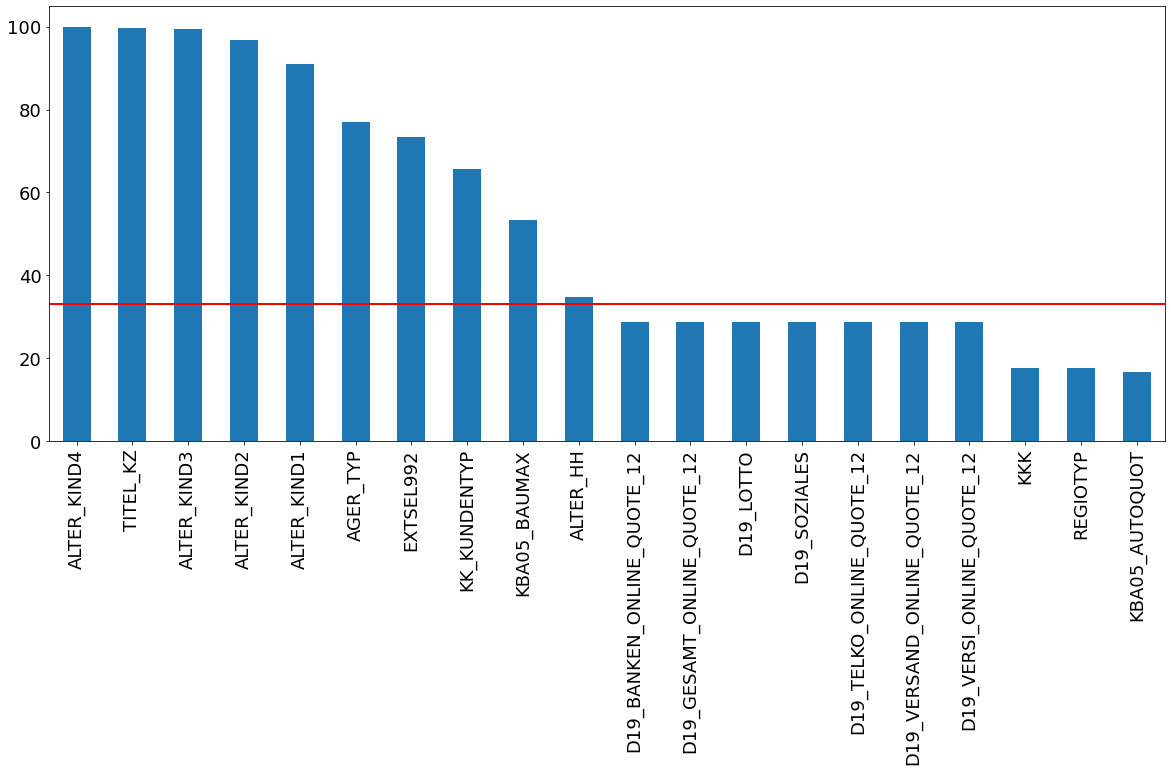

In [1677]:
[azdias_cols_to_drop, azdias_df_3] = drop_cols(azdias_df_2, 33, 20)

In [1087]:
azdias_df_3.shape

(891221, 330)

AGER_TYP        50.475863
ALTER_HH        35.870745
ALTER_KIND1     93.860748
ALTER_KIND2     97.338927
ALTER_KIND3     99.334732
ALTER_KIND4     99.876860
EXTSEL992       44.498883
KBA05_BAUMAX    57.153069
KK_KUNDENTYP    58.406382
TITEL_KZ        98.793647
dtype: float64


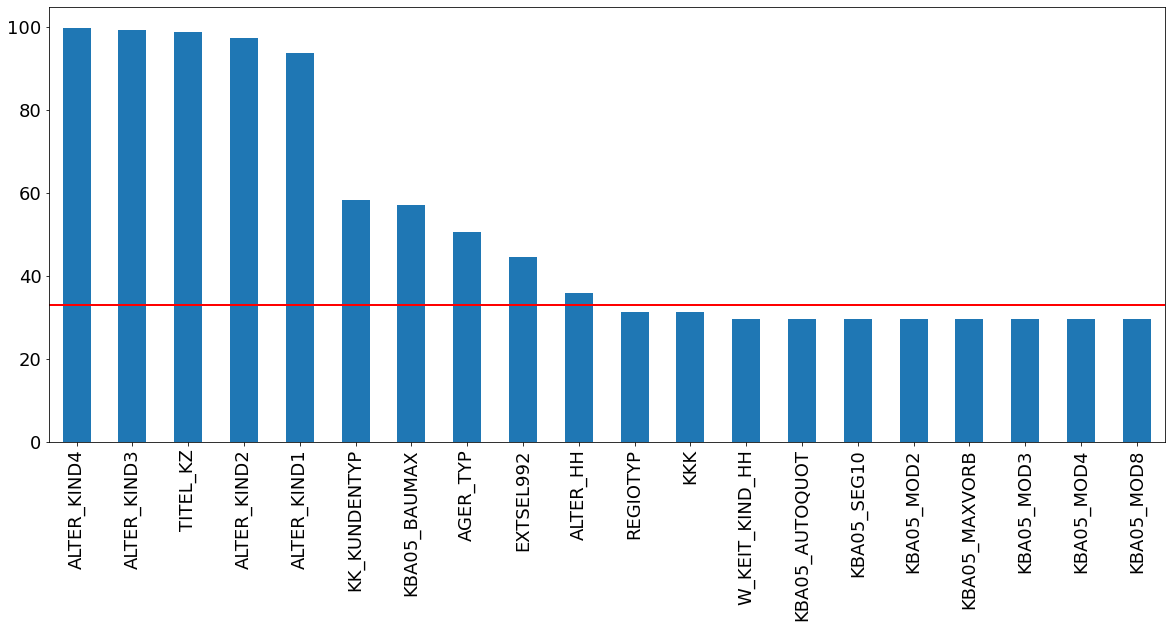

In [1088]:
[customers_cols_to_drop, customers_df_3] = drop_cols(customers_df_2, 33, 20)

In [1089]:
customers_df_2.shape

(191652, 340)

In [1090]:
customers_df_3.shape

(191652, 330)

In [1094]:
azdias_cols_to_drop == customers_cols_to_drop

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### Discussion
The azdias and customer dataset have the same 10 features contains nan more than 33% of the data. These 10 features are dropped.

#### Update the retained_feature_df dataset

In [1092]:
retained_feature_df_1.shape

(340, 4)

In [1097]:
retained_feature_df_3 = retained_feature_df_2.drop(azdias_cols_to_drop,axis=0) 
retained_feature_df_3.shape

(330, 4)

In [1098]:
# save the further cleaned datasets
azdias_df_3.to_pickle('azdias_df_3.pkl')
customers_df_3.to_pickle('customers_df_3.pkl')
retained_feature_df_3.to_pickle('retained_feature_df_3.pkl')

#### Dropping rows with nan more than

In [1678]:
def drop_rows(df, threshold, plot=True):
    
    """
    Description:
        Drop the columns with nan percentage above the threshold
        
    INPUT:
    df - (pandas dataframe) df dataframe
    threshold - (int) percentage of the nan in col
    OUTPUT:
    df -  cleaned pandas dataframe by droping the cols with nans above the threshold   
    """
    
    nan_percent = df.isnull().sum(axis=1) *100 /df.shape[1]
    nan_percent_sorted = nan_percent.sort_values(ascending=False)
    nan_percent_above_threshold = nan_percent[nan_percent > threshold]
#     print (len(nan_percent_above_threshold))
    
    if plot:
        plt.hist(nan_percent_sorted,bins=20)
        plt.show()
    
    rows_to_drop = nan_percent_above_threshold.index
    df = df.drop(rows_to_drop, axis=0)
    
    return rows_to_drop, df
    

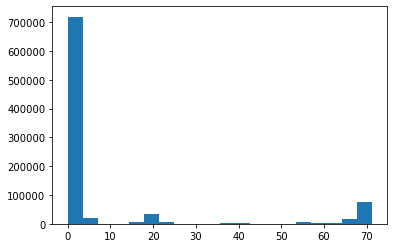

In [1679]:
[azdias_rows_to_drop, azdias_df_4] = drop_rows(azdias_df_3, 33)

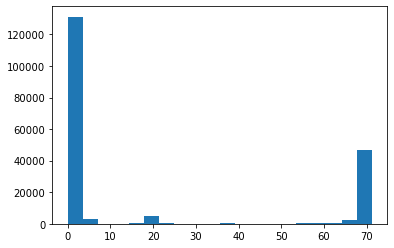

In [1680]:
[customers_rows_to_drop, customers_df_4] = drop_rows(customers_df_3, 33)

In [885]:
nan_percent_row = azdias_df_cleaned_1.isnull().sum(axis=1) *100 /azdias_df_cleaned_1.shape[1]

In [1130]:
azdias_rows_remove_percent = len(azdias_rows_to_drop)/azdias_df_3.shape[0]*100
print ('About {:,.2f}% of data in azdias_df_3 has more than 33% nan,and will be removed'\
       .format(azdias_rows_remove_percent))

About 11.87% of data in azdias_df_3 has more than 33% nan,and will be removed


In [1131]:
customers_rows_remove_percent = len(customers_rows_to_drop)/customers_df_3.shape[0]*100
print ('About {:,.2f}% of data in customers_df_3 has more than 33% nan,and will be removed'\
       .format(customers_rows_remove_percent))

About 26.76% of data in customers_df_3 has more than 33% nan,and will be removed


In [1132]:
azdias_df_4.shape

(785421, 330)

In [1133]:
customers_df_4.shape

(140371, 330)

In [1134]:
# save the further cleaned datasets
retained_feature_df_4 = retained_feature_df_3
azdias_df_4.to_pickle('azdias_df_4.pkl')
customers_df_4.to_pickle('customers_df_4.pkl')
retained_feature_df_3.to_pickle('retained_feature_df_4.pkl')

#### Discussion
For the azdias_df_3 dataset, there are about 100000 data with nan more than 70%, most of the data has less than 30% of nan, and about 11.87% of the data will be dropped. While for the customers_df_3 dataset, about 50000 rows of data has more than 70% of nan, and about 26.76% of data will be dropped. 

The customer dataset has more missing values than the azdias dataset.

#### One-hot encode the categorical features

In [1139]:
def one_hot_cat_cols (df, categorical_features):
     
    """
    Description:
        one-hot encode the categorical features
        
    INPUT:
    df - (pandas dataframe) df dataframe
    categorical_features - (list) categorical_features
    OUTPUT:
    df -  pandas dataframe with categorical features one-hot encoded   
    """    
    categorical_features_in_df = []
    
    for feature in categorical_features:
        if feature in df.columns:
            categorical_features_in_df.append(feature)

    cat_cols = df[categorical_features_in_df]
    
    for col in categorical_features_in_df:
        cat_cols = pd.concat([cat_cols.drop(col, axis=1), 
                              pd.get_dummies(cat_cols[col], prefix=col, prefix_sep='_')],
                              axis=1)
        
    cat_cols = cat_cols.astype('int64')
    df_CatCols_removed = df.drop(categorical_features_in_df,axis=1)
    df_one_hot = pd.concat([df_CatCols_removed, cat_cols], axis=1)
    
    return df_one_hot
    

In [ ]:
azdias_df_5 = one_hot_cat_cols(azdias_df_4, categorical_features)

In [1141]:
azdias_df_5.shape

(785421, 350)

In [1142]:
customers_df_5 = one_hot_cat_cols(customers_df_4, categorical_features)

In [1143]:
customers_df_5.shape

(140371, 350)

In [1144]:
azdias_df_5.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [1145]:
customers_df_5.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [1146]:
# save the further cleaned datasets
azdias_df_5.to_pickle('azdias_df_5.pkl')
customers_df_5.to_pickle('customers_df_5.pkl')

In [1147]:
azdias_df_5.columns

Index(['ALTERSKATEGORIE_GROB', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'BALLRAUM',
       'CAMEO_DEUG_2015', 'CJT_TYP_1', 'CJT_TYP_2',
       ...
       'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0', 'ANREDE_KZ_1',
       'ANREDE_KZ_2', 'NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0',
       'NATIONALITAET_KZ_3.0', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W'],
      dtype='object', length=350)

In [1148]:
customers_df_5.columns

Index(['ALTERSKATEGORIE_GROB', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'BALLRAUM',
       'CAMEO_DEUG_2015', 'CJT_TYP_1', 'CJT_TYP_2',
       ...
       'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0', 'ANREDE_KZ_1',
       'ANREDE_KZ_2', 'NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0',
       'NATIONALITAET_KZ_3.0', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W'],
      dtype='object', length=350)

### Imputing missing values
Idealy, to better impute the missing values, we can use KNN imputer, however, the computation for this large dataset will be time consuming. Thus, I choose to use a sklearn SimpleImputer to fill the missing values with the mode for each feature, which will be the 'most_frequent' strategy.

In [1149]:
def imputing_missing_value(df):
     
    """
    Description:
        imputing the missing values with the mode of each feature
        
    INPUT:
    df - (pandas dataframe) df dataframe
    OUTPUT:
    df -  pandas dataframe with missing value replaced with the mode   
    """
    imputer = SimpleImputer(strategy='most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    
    return df

In [1150]:
azdias_df_6 = imputing_missing_value(azdias_df_5)
azdias_df_6.shape

(785421, 350)

In [1154]:
azdias_df_6.isnull().sum().unique()

array([0])

In [1155]:
customers_df_6 = imputing_missing_value(customers_df_5)
customers_df_6.shape

(140371, 350)

In [1156]:
customers_df_6.isnull().sum().unique()

array([0])

In [1157]:
# save the further cleaned datasets
azdias_df_6.to_pickle('azdias_df_6.pkl')
customers_df_6.to_pickle('customers_df_6.pkl')

### Create a clean function 
Combine all the clean steps above, and create a clean function.

In [1165]:
feature_df_unknowns = retained_feature_df_1
feature_df_unknowns.to_pickle('feature_df_unknowns.pkl')
pickle.dump( features_to_keep, open( "features_to_keep.pkl", "wb" ) )
pickle.dump( features_contain_unknowns_to_keep, 
            open( "features_contain_unknowns_to_keep.pkl", "wb" ) )
pickle.dump( categorical_features, open( "categorical_features.pkl", "wb" ) )

In [1683]:
def clean_df(df, feature_df_unknowns, features_to_keep, features_contain_unknowns_to_keep, 
             threshold, N_top, categorical_features):
    """
    Description:
        Preclean the dataset by engineering new features, replacing unknowns, 
        dropping high-dimensional features, one-hot encode the categorical features 
        and imputing missing values
        
    INPUT:
    df - (pandas dataframe) df dataframe
    feature_df_unknowns -  (pandas dataframe) contains the feature unknown values
    features_to_keep - (list) features to be retained for further analysis 
    features_contain_unknowns_to_keep - (list) features to be retained that has unknowns 
    threshold - (int) percentage of nan 
    N_top - (int) number of the top features contains the most nans
    categorical_features - (list) identified categorical features
    OUTPUT:
    df - (pandas dataframe) cleaned dataset   
    """
    print('Precleaning dataset')
#     df = preclean (df)
    
    print('Retaining the features of interest')
    df = retain_features (df, features_to_keep)
    
    print('Engineering features')
    df = feature_split(df)
    
    print('Repalcing unknowns')
    df = replace_unknown(df, feature_df_unknowns, features_contain_unknowns_to_keep)
    
    print('Dropping columns with nans')
    [cols_to_drop, df] = drop_cols(df, threshold, N_top, False)
    
    print('Dropping rows with nans')
    [rows_to_drop, df] = drop_rows(df, threshold, False)
    
    print('One-hot encoding the categorical features')
    df = one_hot_cat_cols (df, categorical_features)
    
    print('Imputing missing values')
    df = imputing_missing_value(df)
        
    print ('Finished running clean_df')

    return df

In [1218]:
feature_df_unknowns = pickle.load( open( "feature_df_unknowns.pkl", "rb" ) )
features_to_keep = pickle.load( open( "features_to_keep.pkl", "rb" ) )
features_contain_unknowns_to_keep = pickle.load( open( "features_contain_unknowns_to_keep.pkl", "rb" ) )
categorical_features = pickle.load( open( "categorical_features.pkl", "rb" ) )

In [1684]:
threshold = 33
N_top = 20
azdias_cleaned = clean_df(azdias, feature_df_unknowns, features_to_keep, 
                          features_contain_unknowns_to_keep, threshold, 
                          N_top, categorical_features)

Precleaning dataset
Retaining the features of interest
Engineering features
Repalcing unknowns
Dropping columns with nans
Dropping rows with nans
One-hot encoding the categorical features
Imputing missing values
Finished running clean_df


In [1220]:
azdias_cleaned.shape

(785421, 350)

In [1221]:
(azdias_cleaned == azdias_df_6).sum().unique()

array([785421])

In [1227]:
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA1

In [1229]:
azdias_df_6.head()

,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA1

Precleaning dataset
Retaining the features of interest
Engineering features
Repalcing unknowns
Dropping columns with nans
AGER_TYP        50.475863
ALTER_HH        35.870745
ALTER_KIND1     93.860748
ALTER_KIND2     97.338927
ALTER_KIND3     99.334732
ALTER_KIND4     99.876860
EXTSEL992       44.498883
KBA05_BAUMAX    57.153069
KK_KUNDENTYP    58.406382
TITEL_KZ        98.793647
dtype: float64


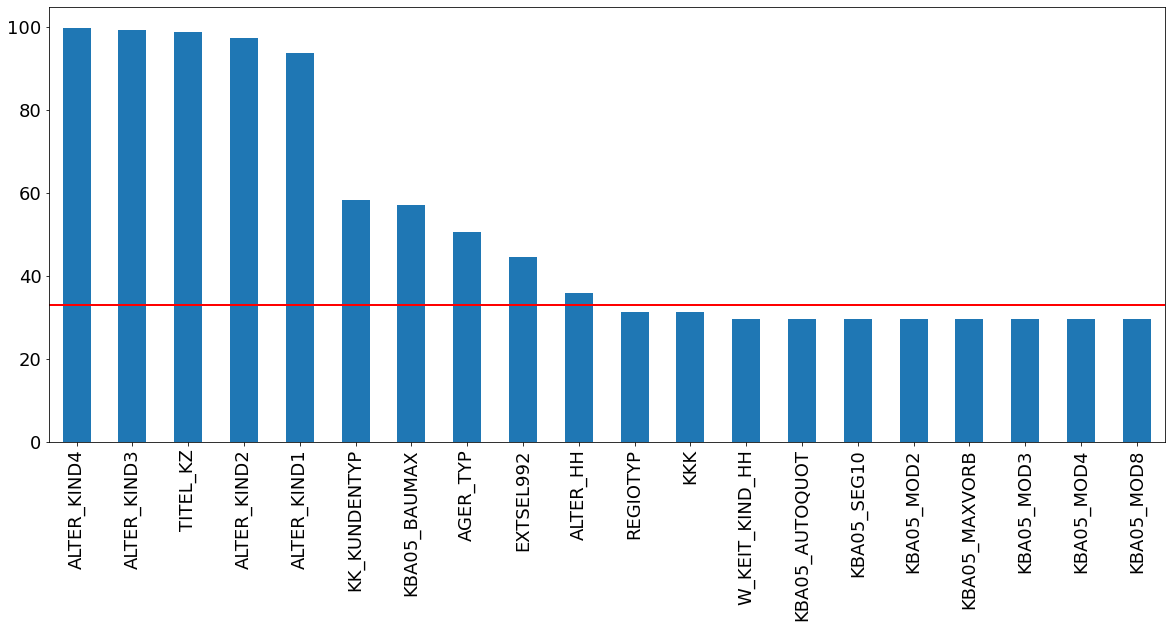

Dropping rows with nans
51281


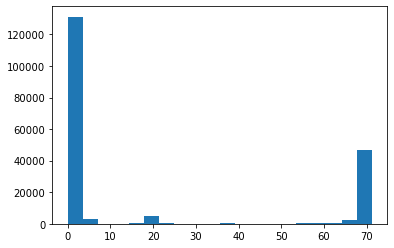

One-hot encoding the categorical features
Imputing missing values
Finished running clean_df


In [1222]:
customers_cleaned = clean_df(customers, feature_df_unknowns, features_to_keep, 
                          features_contain_unknowns_to_keep, threshold, 
                          N_top, categorical_features)

In [1224]:
customers_cleaned.shape

(140371, 350)

In [1223]:
(customers_cleaned == customers_df_6).sum().unique()

array([140371])

In [1225]:
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA1

In [1226]:
customers_df_6.head()

,ALTERSKATEGORIE_GROB,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA1

#### Summary
The combined function generates the same cleaned dataset

In [1230]:
azdias_cleaned.to_pickle('azdias_cleaned.pkl')
customers_cleaned.to_pickle('customers_cleaned.pkl')

## Summary

After combing through DIAS Attributes description file, a DataFrame retained_feature_df_1 is created with all the retained features, including their description, type, encode/normalize strategy, and unknown values. The original azdias dataset has been cleaned based on the retained_feature_df_1 by setting the relavant unknown values to NaN, dropping rows and cols with more than 30% nan, and one-hot encoding the categorical features. The cleaned azdias dataset is saved as azdias_df_cleaned_3 with 350 features.

#### Pipeline so far:

1. Select features in df[cols_keep]
2. Use unknown_to_nan() to convert unknown to NaN
3. Use onehot_encode_df() to onehot encode categorical features
4. Use split_cameo_deuintl_2015() to split the cameo_deuintl_2015 into two features
5. Use remove_string_values() to remove any string values 
6. Use binarize_nan() to binarize chosen features
7. Use standardise_binary_features() to binarize chosen features
8. Use drop_sparse_samples() to remove samples with too many features missing
9. Use to_float() to ensure dataframe is all floats


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Feature scaling

In [1158]:
scaler = StandardScaler()
scaler.fit(azdias_cleaned)

azdias_df_scaled = pd.DataFrame(scaler.transform(azdias_cleaned), 
                                columns = azdias_cleaned.columns)
customers_df_scaled = pd.DataFrame(scaler.transform(customers_cleaned), 
                                   columns = customers_cleaned.columns)


### 1.2 Principal component analysis

In [1270]:
SEED = 42
def pca_fit(df, n_components=None):
    """
    Description:
        Pricipal component analysis
        
    INPUT:
    df - (pandas dataframe) df dataframe
    n_components -  (int) number of components to keep
    OUTPUT:
    pca - Principal component analysis
    df_transformed - (pandas dataframe) transformed df dataframe
    """    
    pca = PCA(n_components, random_state=SEED)
    pca.fit(df)
    df_transformed = pca.transform(df)
    return pca, df_transformed

In [1239]:
pca_azdias, _ = pca_fit(azdias_df_scaled)

In [1269]:
pca_azdias

PCA(random_state=42)

In [1260]:
def plot_exp_var(df, pca):
    
    """
    Description:
        plot the explained variance
        
    INPUT:
    df - (pandas dataframe) df dataframe
    pca - Principal component analysis 
    OUTPUT:
    
    """ 
    
    for i in np.linspace(0.3,0.9,7):
        print(f'Number of dimensions:{np.searchsorted(np.cumsum(pca.explained_variance_ratio_),i)}\
         that explain variance of {int(i*100)}%')
    
    figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components', fontsize=14)
    plt.ylabel('cumulative explained variance', fontsize=14);

    figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(pca.explained_variance_ratio_)
#     plt.xticks(list(range(0,(len(df.columns)),50)))
    plt.xlabel('number of components', fontsize=14)
    plt.ylabel('explained variance', fontsize=14);

Number of dimensions:8         that explain variance of 30%
Number of dimensions:16         that explain variance of 40%
Number of dimensions:30         that explain variance of 50%
Number of dimensions:50         that explain variance of 60%
Number of dimensions:79         that explain variance of 70%
Number of dimensions:118         that explain variance of 80%
Number of dimensions:171         that explain variance of 90%


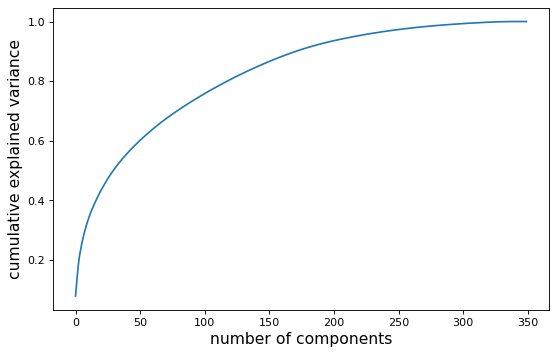

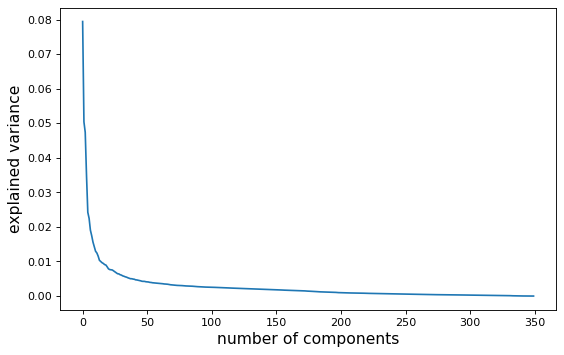

In [1261]:
plot_exp_var(azdias_df_scaled, pca_azdias)

#### Discussion
We can see that, 90% of the variance is explained when the number of components is 171. Thus, the number of components can be set as 171 and we can perform the PCA to see the feature importance.

In [1271]:
## set the number of components to 171 and perform PCA
pca_azdias_171, azdias_pca_171 = pca_fit(azdias_df_scaled, 171)

### 1.3 Feature importance
Now I will look at the feature importance 

In [1272]:
retained_feature_df_4.head()

,description,type,normalization,unknown
feature,,,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,ordinal,Std,"[-1, 0, 9]"
ANREDE_KZ,gender,categorical,OneHot,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,numerical,Std,NaN
ANZ_HH_TITEL,number of academic title holder in building,numerical,Std,NaN
ANZ_PERSONEN,number of adult persons in the household,numerical,Std,NaN


In [1549]:
def plot_feature_weights(df, pca, retained_feature_df, dimension, 
                         n_weights = 5, plot=True,figsize=(6,5)):

    """
    Description:
        plot the features of the selected dimension
        
    INPUT:
    df - (pandas dataframe) df dataframe
    pca - Principal component analysis model
    dimension - (int) number of dimensions of interest
    n_weights - (int)
    OUTPUT:
    
    """     
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_dscps = []
    # features with top negative importance
    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
    # features with top positive importance    
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
    # feature descriptions
    for feature in feat_names:
        if feature not in retained_feature_df.index:
            feature = '_'.join(feature.split('_')[:-1])
        feat_dscps.append(retained_feature_df.loc[feature, 'description'])
    
    component_info = {"Feature":feat_names, "Description":feat_dscps, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info['abs_weight'] = component_info['FeatureWeight'].apply(lambda x: np.abs(x))
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    if plot:
#         fig = plt.figure(figsize=figsize)
        ax=plt.subplots(figsize=figsize)
        ax=sns.barplot(data=component_info,
                      x="FeatureWeight",
                      y="Feature",
                      palette="vlag") # rocket, Blues_d
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        plt.show()
    
    return component_info

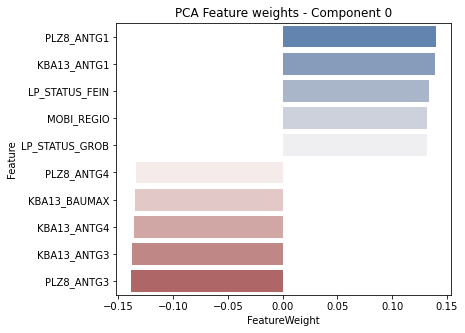

,Feature,Description,FeatureWeight,abs_weight
0,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.139814,0.139814
1,KBA13_ANTG1,NaN,0.139500,0.139500
2,LP_STATUS_FEIN,social status fine,0.134057,0.134057
3,MOBI_REGIO,moving patterns,0.132037,0.132037
4,LP_STATUS_GROB,social status rough,0.131529,0.131529
5,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.133849,0.133849
6,KBA13_BAUMAX,NaN,-0.134719,0.134719
7,KBA13_ANTG4,NaN,-0.135200,0.135200
8,KBA13_ANTG3,NaN,-0.137843,0.137843
9,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.137991,0.137991


In [1550]:
component_0_weights = plot_feature_weights(azdias_df_scaled, pca_azdias, 
                                           retained_feature_df_4, 0)
component_0_weights.head(10)

#### Discussion

* Observed from feature 'PLZ8_ANTG*' and 'KBA13_ANTG*', high postive weight for 'number of 1-2 family houses' in the neighbourhood and high negative weight to number of 6-10 or > 10 family houses.
* Observed from feature 'LP_STATUS_FEIN' and 'LP_STATUS_GROB', high postive weight for the social status 
* Observed from feature 'MOBI_REGIO', high positive weight for moving patterns

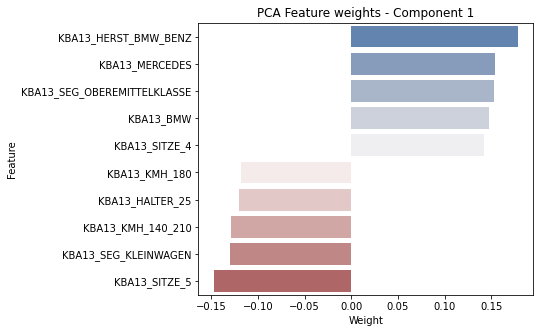

,Feature,Description,Weight,abs_weight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.178870,0.178870
1,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.154337,0.154337
2,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.152590,0.152590
3,KBA13_BMW,share of BMW within the PLZ8,0.147734,0.147734
4,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,0.141946,0.141946
5,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.118793,0.118793
6,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,-0.120628,0.120628
7,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.128514,0.128514
8,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.129708,0.129708
9,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.147636,0.147636


In [1363]:
component_1_weights = plot_feature_weights(azdias_df_scaled, pca_azdias, 
                                           retained_feature_df_4, 1)
component_1_weights.head(10)

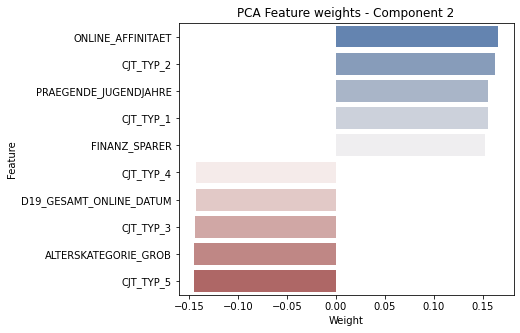

,Feature,Description,Weight,abs_weight
0,ONLINE_AFFINITAET,online affinity,0.166061,0.166061
1,CJT_TYP_2,NaN,0.163125,0.163125
2,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.155823,0.155823
3,CJT_TYP_1,NaN,0.155505,0.155505
4,FINANZ_SPARER,financial typology: money saver,0.152003,0.152003
5,CJT_TYP_4,NaN,-0.143338,0.143338
6,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.143618,0.143618
7,CJT_TYP_3,NaN,-0.144667,0.144667
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,-0.144808,0.144808
9,CJT_TYP_5,NaN,-0.145342,0.145342


In [1364]:
component_2_weights = plot_feature_weights(azdias_df_scaled, pca_azdias, 
                                           retained_feature_df_4, 2)
component_2_weights.head(10)

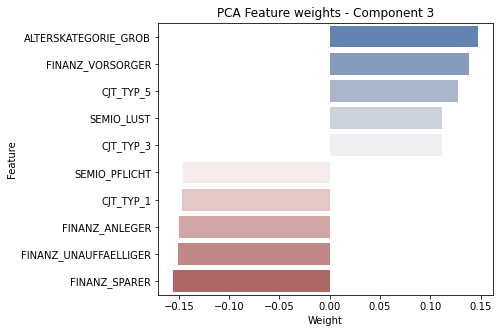

,Feature,Description,Weight,abs_weight
0,ALTERSKATEGORIE_GROB,age classification through prename analysis,0.147141,0.147141
1,FINANZ_VORSORGER,financial typology: be prepared,0.138836,0.138836
2,CJT_TYP_5,NaN,0.127362,0.127362
3,SEMIO_LUST,affinity indicating in what way the person is ...,0.111568,0.111568
4,CJT_TYP_3,NaN,0.111163,0.111163
5,SEMIO_PFLICHT,affinity indicating in what way the person is ...,-0.145457,0.145457
6,CJT_TYP_1,NaN,-0.146867,0.146867
7,FINANZ_ANLEGER,financial typology: investor,-0.149383,0.149383
8,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,-0.150955,0.150955
9,FINANZ_SPARER,financial typology: money saver,-0.155411,0.155411


In [1365]:
component_3_weights = plot_feature_weights(azdias_df_scaled, pca_azdias, 
                                           retained_feature_df_4, 3)
component_3_weights.head(10)

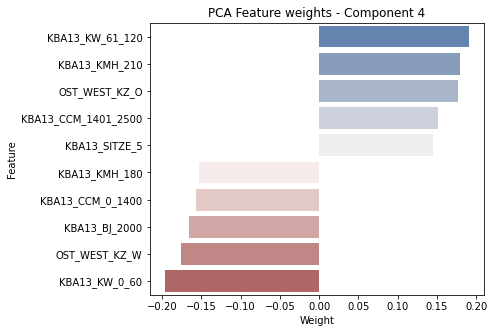

,Feature,Description,Weight,abs_weight
0,KBA13_KW_61_120,share of cars with an engine power between 61 ...,0.190950,0.190950
1,KBA13_KMH_210,NaN,0.179097,0.179097
2,OST_WEST_KZ_O,flag indicating the former GDR/FRG,0.176163,0.176163
3,KBA13_CCM_1401_2500,NaN,0.151253,0.151253
4,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,0.145473,0.145473
5,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.152501,0.152501
6,KBA13_CCM_0_1400,share of cars with less than 1400ccm within th...,-0.157206,0.157206
7,KBA13_BJ_2000,share of cars built between 2000 and 2003 with...,-0.165708,0.165708
8,OST_WEST_KZ_W,flag indicating the former GDR/FRG,-0.176163,0.176163
9,KBA13_KW_0_60,share of cars up to 60 KW engine power - PLZ8,-0.196674,0.196674


In [1366]:
component_4_weights = plot_feature_weights(azdias_df_scaled, pca_azdias, 
                                           retained_feature_df_4, 4)
component_4_weights.head(10)

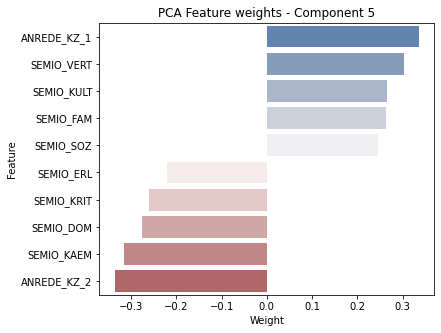

,Feature,Description,Weight,abs_weight
0,ANREDE_KZ_1,gender,0.336350,0.336350
1,SEMIO_VERT,affinity indicating in what way the person is ...,0.303322,0.303322
2,SEMIO_KULT,affinity indicating in what way the person is ...,0.264528,0.264528
3,SEMIO_FAM,affinity indicating in what way the person is ...,0.262967,0.262967
4,SEMIO_SOZ,affinity indicating in what way the person is ...,0.244557,0.244557
5,SEMIO_ERL,affinity indicating in what way the person is ...,-0.219603,0.219603
6,SEMIO_KRIT,affinity indicating in what way the person is ...,-0.259785,0.259785
7,SEMIO_DOM,affinity indicating in what way the person is ...,-0.276799,0.276799
8,SEMIO_KAEM,affinity indicating in what way the person is ...,-0.316400,0.316400
9,ANREDE_KZ_2,gender,-0.336350,0.336350


In [1367]:
component_5_weights = plot_feature_weights(azdias_df_scaled, pca_azdias, 
                                           retained_feature_df_4, 5)
component_5_weights.head(10)

#### Discussion


In [1334]:
azdias_df_cleaned.shape

(891221, 329)

### 1.4 Customer Segmentation - K-Means Clustering
After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [1390]:
def get_Kmeans_inertia(df, K_start, K_end, step=1):
    
    """
    Description:
        perform K-Means clustering and display the inertia vs. number of clusters
        
    INPUT:
    df - (pandas dataframe) df dataframe
    K_start - (int) starting number of clusters
    K_end - (int) ending number of clusters
    step - (int) iteration step
    OUTPUT:
    inertia - (list) Sum of squared distances of samples to their closest cluster center for 
                     each number of cluster
    """ 
    inertia = []
    
    print("Performing K-Means clustering")
    print("Given range K_start:{}, K_end:{}, step:{}".format(K_start, K_end, step))

    for k in range(K_start, K_end+1, step):
        
        print("\nTraining for {} clusters:".format(k))
        start = time.time()
        
        kmeans = KMeans(k, random_state=SEED)
        model = kmeans.fit(df)
        inertia.append(model.inertia_)
        
        print("Done! inertia: ", inertia[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return inertia, range(K_start, K_end+1, step)

In [1391]:
%%time
inertia, range_ = get_Kmeans_inertia(azdias_pca_171, 2, 20, 1)

Performing K-Means clustering
Given range K_start:2, K_end:20, step:1

Training for 2 clusters:
Done! Score:  231214646.32854742
Time elapsed: 13.06 sec.

Training for 3 clusters:
Done! Score:  223837075.70332092
Time elapsed: 19.54 sec.

Training for 4 clusters:
Done! Score:  218929705.58635598
Time elapsed: 28.97 sec.

Training for 5 clusters:
Done! Score:  215250900.02799988
Time elapsed: 36.48 sec.

Training for 6 clusters:
Done! Score:  212220083.40234983
Time elapsed: 44.31 sec.

Training for 7 clusters:
Done! Score:  209731882.81603816
Time elapsed: 50.90 sec.

Training for 8 clusters:
Done! Score:  207700092.26648265
Time elapsed: 58.16 sec.

Training for 9 clusters:
Done! Score:  205964669.7045374
Time elapsed: 72.39 sec.

Training for 10 clusters:
Done! Score:  204516530.36833924
Time elapsed: 95.50 sec.

Training for 11 clusters:
Done! Score:  203412742.29547623
Time elapsed: 90.11 sec.

Training for 12 clusters:
Done! Score:  202216941.35438454
Time elapsed: 95.28 sec.

Tra

In [1395]:
inertia =[231214646.32854742, 223837075.70332092, 218929705.58635598, 215250900.02799988,
          212220083.40234983, 209731882.81603816, 207700092.26648265, 205964669.7045374,
          204516530.36833924, 203412742.29547623, 202216941.35438454, 201350778.66968802,
          200456482.27033868, 199662404.53139335, 198832523.6834701,  198178517.95435426, 
          197522645.9915499,  196800110.86316192, 196210094.60886773]

In [1433]:
def plot_inertia(inertia, range_):
    """
    Description:
        Plot the inertia vs number of clusters
        
    INPUT:
        inertia - (list) Sum of squared distances of samples to their closest cluster center 
        for each number of cluster
        range_ - (list) number of clusters
        
    OUTPUT:
    
    """ 
    slope = shift(inertia, 1)[1:]-inertia[1:]
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(211)
    
    ax1.plot(range_, inertia, linestyle= "--",marker = "o", color="green")
    ax1.set_xlabel("No. of Clusters")
    ax1.set_ylabel("Sum of squared distances")
    ax1.set_title("Kmeans - Cluster distances vs No. of Clusters")
    ax1.set_xlim(1,20)
    plt.show()
    
    fig = plt.figure(figsize=(8,6))
    ax2 = fig.add_subplot(212)
    
    ax2.plot(range_[1:], slope, linestyle= "--",marker = "o", color="red")
    ax2.set_xlabel("No. of Clusters")
    ax2.set_ylabel("slope")
    ax2.set_title("Kmeans - Slope vs No. of Clusters")
    ax2.set_xlim(1,20)
    plt.show()

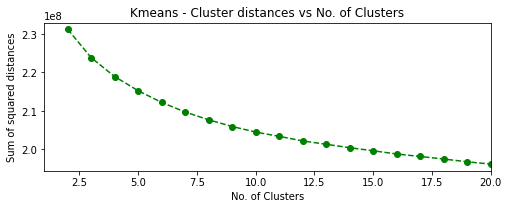

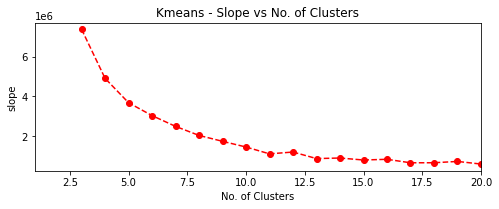

In [1434]:
plot_inertia(inertia, range_)

### 1.5 Selecting appropriate number of clusters

In this project, the Elbow method is used to select the appropriate number of clusters in order to  minimize the intra-cluster variation. The total intra-cluster variation measures the compactness of the clustering and we want it to be as small as possible.

The Elbow method looks at the total intra-cluster variation as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn’t improve the total intra-cluster variation significantly. [[1]](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/)

In the plotted figure inertia vs number of clusters, the inertia decreasing speed does not change significantly at around **11 clusters** and the slope is almost flat. Thus, 11 clusters will be used for the customer segmentation.

In [1435]:
k_cluster = 11
kmeans = KMeans(k_cluster, random_state=SEED)
model = kmeans.fit(azdias_pca_171)
model

KMeans(n_clusters=11, random_state=42)

In [1436]:
customers_pca_171 = pca_azdias_171.transform(customers_df_scaled)

In [1437]:
azdias_clusters = model.predict(azdias_pca_171)
customers_clusters = model.predict(customers_pca_171)

In [1442]:
azdias_clusters = pd.Series(azdias_clusters)
customers_clusters = pd.Series(customers_clusters)

In [1447]:
azdias_clusters.value_counts().sort_index()

0     73264
1     99205
2     97670
3     95562
4     60412
5     98909
6     38606
7     46995
8     64940
9     56322
10    53536
dtype: int64

In [1448]:
customers_clusters.value_counts().sort_index()

0       946
1     30700
2      1608
3     16945
4      3065
5     31709
6      4908
7      6281
8     38114
9      2674
10     3421
dtype: int64

In [1450]:
labels, azdias_cluster_counts = np.unique(azdias_clusters, return_counts=True)

In [1457]:
_, customers_cluster_counts = np.unique(customers_clusters, return_counts=True)

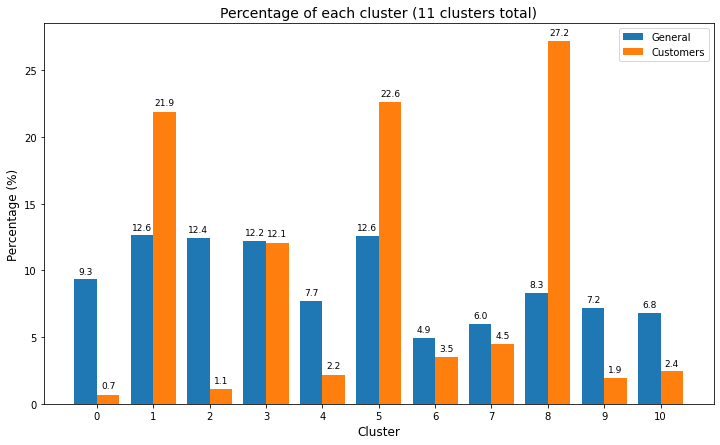

In [1494]:
azdias_cluster_percent = azdias_cluster_counts*100/len(azdias_clusters)
customers_cluster_percent = customers_cluster_counts*100/len(customers_clusters)
x = np.arange(len(labels))*2  # the label locations
width = 0.8 # the width of the bars

fig, ax = plt.subplots(figsize=(12,7))
rects1 = ax.bar(x - width/2, azdias_cluster_percent, width, label='General')
rects2 = ax.bar(x + width/2, customers_cluster_percent, width, label='Customers')
ax.set_xlabel('Cluster' ,fontsize = 12)
ax.set_ylabel('Percentage (%)' ,fontsize = 12)
ax.set_title('Percentage of each cluster ({0} clusters total)'.format(k_cluster),fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', size=9)

autolabel(rects1)
autolabel(rects2)

plt.show()

#### Discussion
From the figure above, we can observe that cluster 1, 5 and 8 in the customers dataset have significantly higher percentage compared to the general pupulation. Thus, people have similar democraphic properties compared to cluster 1, 5 and 8 will have higher chance as potential customers and can be selected as future marketing target.

### 1.6 Cluster Interpretation
In this following section, the three clusters 1, 5 and 8 will be studied. The PCA component as well as feature weights that affect the cluster the most will be discussed. For convenience, only the top 2 components (highest weight) and the relative top 5 postive features and top 5 negative features are discussed.

In [1662]:
def interpret_cluster(kmeans_model, cluster_no, df, pca, retained_feature_df, 
                     num_components=2, num_feat_per_comp=5, plot=True):
    """
    Description:
        extract the component and relative feature info using the kmeans_model
        
    INPUT:
    kmeans_model - K-Means model 
    cluster_no - (int) cluster number of interest 
    df - (pandas dataframe) df dataframe
    pca - Principal component analysis model
    retained_feature_df - (pandas dataframe) number of dimensions of interest
    num_components - (int) number of the top components of interest
    num_feat_per_comp - (int) number of features of interest for each component

    OUTPUT:
    cluster_info - () comopents weights for cluster of interest
    cluster_component_info - () top components and relavant features for cluster of interest
    """   
    comp_weights = kmeans_model.cluster_centers_[cluster_no]
    comps = list(range(len(comp_weights)))    
    cluster_info = pd.DataFrame({ "Component":components, "ComponentWeight":comp_weights})
    cluster_info['Abs_Weight'] = cluster_info['ComponentWeight'].apply(lambda x: np.abs(x))
    cluster_info1 = cluster_info.sort_values("Abs_Weight", ascending=False, ignore_index=True)
    
    cluster_info2 = pd.DataFrame(cluster_info1.head(10)).sort_values("ComponentWeight", ascending=False)
    cluster_info2['Component'] = cluster_info2['Component'].apply(lambda x: 'Component_'+ str(x))
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax=sns.barplot(data = cluster_info2,
                      y="Component",
                      x="ComponentWeight",
                      palette="vlag") # rocket, Blues_d
        ax.set_title("Component weights of cluster {}".format(cluster_no))
        plt.show()

    comps = []
    weights = []
    abs_weights = []
    comp_infos = []
    
    for index, row in cluster_info1.head(num_components).iterrows():
        
        feature_weights = plot_feature_weights(df, pca, retained_feature_df, 
                                                 int(row["Component"]), 
                                                 num_feat_per_comp, True)
#         print (feature_weights)
        comp_infos.append(feature_weights)
        comps += [int(row["Component"])] * len( feature_weights)
        weights +=  [row["ComponentWeight"]] * len( feature_weights)
        abs_weights +=  [row["Abs_Weight"]] * len( feature_weights)
        
    cluster_component_info = pd.concat(comp_infos, ignore_index=True)
    cluster_component_info.insert(0, "Abs_Weight", pd.Series(abs_weights))
    cluster_component_info.insert(0, "ComponentWeight", pd.Series(weights))
    cluster_component_info.insert(0, "Component", pd.Series(comps))
    
        
    return cluster_info, cluster_component_info

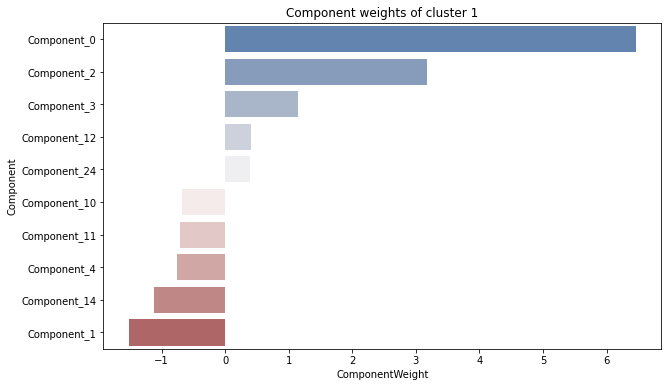

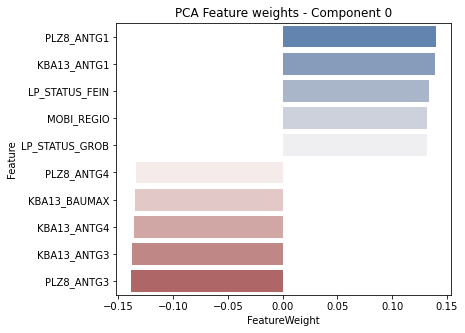

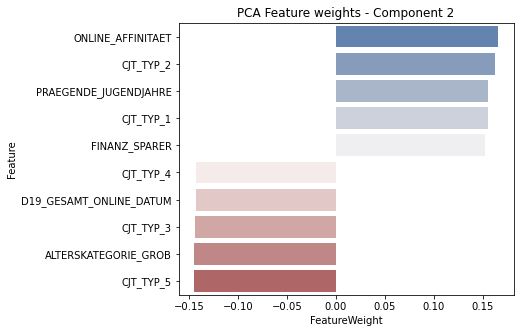

,Component,ComponentWeight,Abs_Weight,Feature,Description,FeatureWeight,abs_weight
0,0,6.464801,6.464801,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.139814,0.139814
1,0,6.464801,6.464801,KBA13_ANTG1,NaN,0.139500,0.139500
2,0,6.464801,6.464801,LP_STATUS_FEIN,social status fine,0.134057,0.134057
3,0,6.464801,6.464801,MOBI_REGIO,moving patterns,0.132037,0.132037
4,0,6.464801,6.464801,LP_STATUS_GROB,social status rough,0.131529,0.131529
5,0,6.464801,6.464801,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.133849,0.133849
6,0,6.464801,6.464801,KBA13_BAUMAX,NaN,-0.134719,0.134719
7,0,6.464801,6.464801,KBA13_ANTG4,NaN,-0.135200,0.135200
8,0,6.464801,6.464801,KBA13_ANTG3,NaN,-0.137843,0.137843
9,0,6.464801,6.464801,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.137991,0.137991


In [1670]:
cluster_no = 1
cluster_0_info, cluster_0_component_info = interpret_cluster(model, cluster_no, azdias_df_scaled, pca_azdias_171, retained_feature_df_4)
cluster_0_component_info

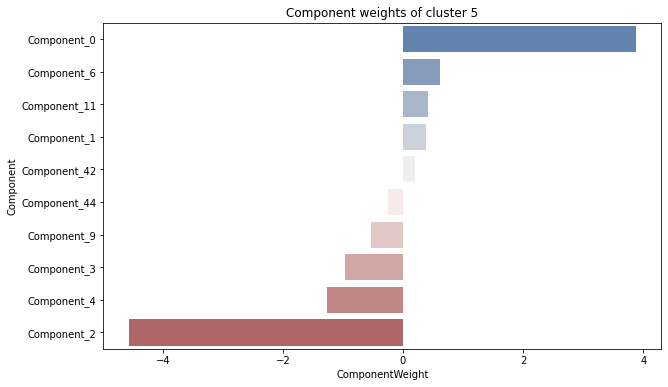

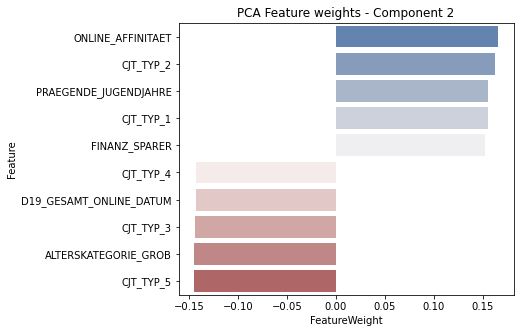

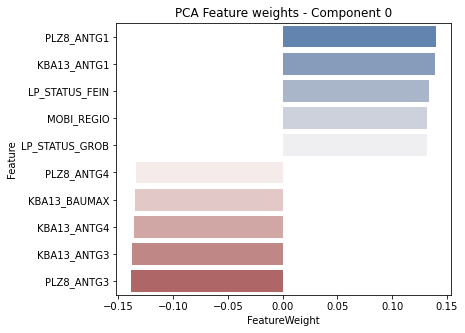

,Component,ComponentWeight,Abs_Weight,Feature,Description,FeatureWeight,abs_weight
0,2,-4.566456,4.566456,ONLINE_AFFINITAET,online affinity,0.166061,0.166061
1,2,-4.566456,4.566456,CJT_TYP_2,NaN,0.163125,0.163125
2,2,-4.566456,4.566456,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.155823,0.155823
3,2,-4.566456,4.566456,CJT_TYP_1,NaN,0.155505,0.155505
4,2,-4.566456,4.566456,FINANZ_SPARER,financial typology: money saver,0.152003,0.152003
5,2,-4.566456,4.566456,CJT_TYP_4,NaN,-0.143338,0.143338
6,2,-4.566456,4.566456,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.143618,0.143618
7,2,-4.566456,4.566456,CJT_TYP_3,NaN,-0.144667,0.144667
8,2,-4.566456,4.566456,ALTERSKATEGORIE_GROB,age classification through prename analysis,-0.144808,0.144808
9,2,-4.566456,4.566456,CJT_TYP_5,NaN,-0.145342,0.145342


In [1671]:
cluster_no = 5
cluster_5_info, cluster_5_component_info = interpret_cluster(model, cluster_no, azdias_df_scaled, pca_azdias_171, retained_feature_df_4)
cluster_5_component_info

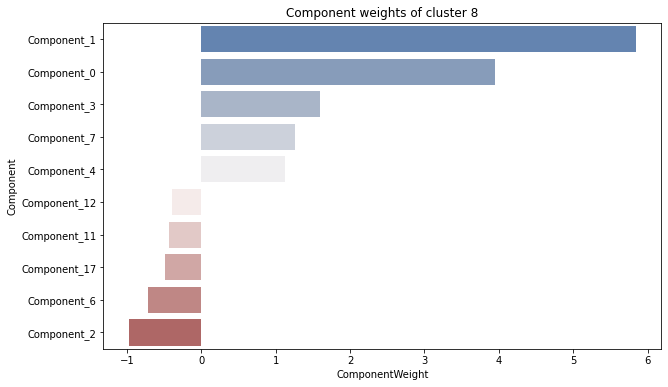

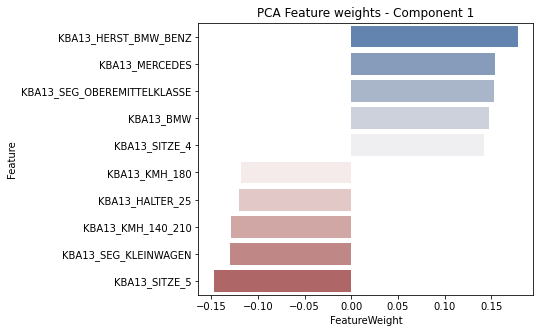

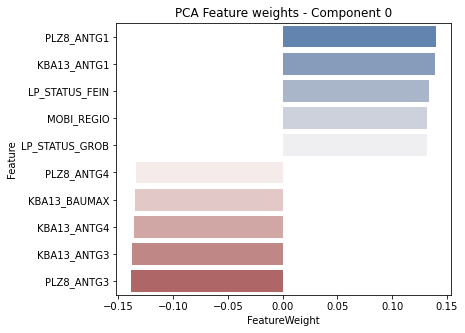

,Component,ComponentWeight,Abs_Weight,Feature,Description,FeatureWeight,abs_weight
0,1,5.846474,5.846474,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.178870,0.178870
1,1,5.846474,5.846474,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.154337,0.154337
2,1,5.846474,5.846474,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.152590,0.152590
3,1,5.846474,5.846474,KBA13_BMW,share of BMW within the PLZ8,0.147734,0.147734
4,1,5.846474,5.846474,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,0.141946,0.141946
5,1,5.846474,5.846474,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.118793,0.118793
6,1,5.846474,5.846474,KBA13_HALTER_25,share of car owners between 21 and 25 within t...,-0.120628,0.120628
7,1,5.846474,5.846474,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.128514,0.128514
8,1,5.846474,5.846474,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.129708,0.129708
9,1,5.846474,5.846474,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.147636,0.147636


In [1672]:
cluster_no = 8
cluster_8_info, cluster_8_component_info = interpret_cluster(model, cluster_no, azdias_df_scaled, pca_azdias_171, retained_feature_df_4)
cluster_8_component_info

#### Discussion
From the figures and cluster info above, we can observe that component 0 and 2 affect cluster 1 and 5 the most, and component 0 and 1 affect cluster 8 the most.  Component 0 and 2 both have postiove effect on cluster 1, while component has positive effect and component 2 has negative effect on cluster 5. Component 0 and 1 affect cluster the most and they both have postive effect.

Looking at the top features in component 0:

* Observed from feature 'PLZ8_ANTG*' and 'KBA13_ANTG*', high postive weight for 'number of 1-2 family houses' in the neighbourhood and high negative weight to number of 6-10 or > 10 family houses.
* Observed from feature 'LP_STATUS_FEIN' and 'LP_STATUS_GROB', high postive weight for the social status 
* Observed from feature 'MOBI_REGIO', high positive weight for moving patterns

Top features in component 1: 

* Observed from feature 'KBA13_HERST_BMW_BENZ', 'KBA13_MERCEDES', 'KBA13_BMW', and 'KBA13_SEG_OBEREMITTELKLASSE', the higher the share of BMW & Mercedes, and/or share of upper middle class cars and upper class cars, the higher chance the personel is a potential customer 
* Observed from feature 'KBA13_SITZE_4' and 'KBA13_SITZE_5', number of cars with less that 5 seats (sports car or sedan) has postitive effect while that more than 5 seats (SUV, van) has negative effects 

Top features in component 2: (Reminder: CJT refers to customer journey typology )

* Observed from feature 'ONLINE_AFFINITAET', the higher the online affinity and , the higher chance the personel is a potential customer 
* Observed from feature 'CJT_TYP*', type 1 and 2 has positive weight while type 3, 4, and 5 have negative weight
* Observed from feature 'D19_GESAMT_ONLINE_DATUM', high negative weight indicate that the higher the transaction activity, the the higher chance the personel is a potential customer 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')